In [1]:
import numpy as np
from time import time
from matplotlib import pyplot as plt
from numba import jit
from tqdm import tqdm
import numba
from scipy import interpolate

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('font', size='22')
#plt.rcParams['figure.dpi'] = 150
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['xtick.minor.width'] = 1.5
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2
plt.rcParams['ytick.minor.size'] = 5
plt.rcParams['ytick.minor.width'] = 1.5

In [3]:
import sys
sys.path.append('/home/addis/PkBk/Library')
sys.path.append('/home/addis/PkBk/Scripts')
import get_field as gf
import compute_grid_info as cgi
import Pk 
import Pk_one 
import Pk_class

In [4]:
#load field from file on server...
###skip if have own field


path = '../../../data/Quijote/' #path to folder containing quijote files.
N_side = 128
rsd_direction = '' # 'z'

redshift = '/snapdir_004/snap_004'
if redshift[-1] == str(4):
    red_info = 'z=0'
elif redshift[-1] == str(2):
    red_info = 'z=1'
else:
    red_info = 'z=NA'


In [5]:
%%time
#define grid information
Nside=128               #grid resolution
L=1000                  #size of box Mpc/h
rfft=False              #use real ffts?
order=2                 #order MAS correction 2- CIC
dtype=np.complex64      #np.complex128 also allowed - single or double precision
threads=4               #no. threads for pyfftw to use
verbose=True    

obs_pos=(0,0,-1e+10)         #position of observer defined from centre of box
realisation = str(10015)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '.npy')#+ '_LOS=PP' #load field

#get array of statistics for grid
grid_info = cgi.compute_survey(Nside,L,rfft,order,obs_pos) #xi,x_norm,ki,k_mag,MAS,k_f,k_ny
grid_info1 = cgi.compute_survey(Nside,L,True,order,obs_pos)#xi,x_norm,ki,k_mag,MAS,k_f,k_ny

CPU times: user 15.2 s, sys: 135 ms, total: 15.3 s
Wall time: 16.4 s


In [6]:
xi,x_norm,ki,k_mag,MAS,k_f,k_ny = grid_info

In [7]:
%%time
s=1 #size of bins in units of 2*k_f
k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f

#compute binning information
binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])#In_bin,N_modes
binning_info1 = cgi.pk_compute_bins(k_est,s,grid_info1[3],grid_info1[5])#In_bin,N_modes

CPU times: user 5.4 s, sys: 34.7 ms, total: 5.44 s
Wall time: 9.89 s


In [8]:
#define stuff related to each multipole
t= 0
l = 1
exorder = 0 #order in x_12/d expansion in estimator

In [9]:
%%time
class_pk = Pk_class.Pk(field_tmp,L,k_est,grid_info,binning_info,False,dtype,threads,rfft,verbose)
class_pk1 = Pk_class.Pk(field_tmp,L,k_est,grid_info1,binning_info1,False,dtype,threads,True,verbose)

CPU times: user 1.46 ms, sys: 0 ns, total: 1.46 ms
Wall time: 6.18 ms


In [10]:
%%time
pkl = class_pk.get_Pk(field_tmp,l,exorder,t)

CPU times: user 1 s, sys: 79.3 ms, total: 1.08 s
Wall time: 1.37 s


In [11]:
%%time
pkl1 = class_pk1.get_Pk(field_tmp,l,exorder,t)

CPU times: user 356 ms, sys: 13.6 ms, total: 370 ms
Wall time: 396 ms


In [12]:
#dir(class_pk)

In [13]:
k_mag_ = np.where(k_mag==0,1e+5,k_mag)

In [99]:
d01 = class_pk.Qpqrs(field_tmp,xi/x_norm,ki,1) # so with mu 
delta_k = class_pk.FFTW_fft(field_tmp)
field_mu = class_pk.FFTW_ifft(1j*d01/k_mag_)
field_mu1 = class_pk.FFTW_ifft(delta_k/k_mag_)#class_pk.FFTW_ifft(1j*d01/k_mag_)

In [28]:
print(field_mu[100,30,20:30])
print(field_mu1[100,30,20:30])

[-8.525537 -0.02305396j -6.054004 +0.0230527j  -7.050871 -0.02305351j
 -6.9561033+0.02305302j -9.567505 -0.0230535j  -8.182814 +0.02305239j
 -5.516511 -0.02305364j -3.851706 +0.02305329j -1.3436865-0.02305329j
  2.2494998+0.02305396j]
[ 3.1474996-3.7367522e-07j  3.2546434+9.2808557e-07j
  3.369051 -5.4407315e-07j  3.3586197+6.9651202e-07j
  2.3488166-1.4054395e-06j -3.7322083-3.6351908e-06j
 -5.281214 -1.6929253e-06j -6.614931 -1.8514407e-06j
 -7.0247984-1.2353033e-06j -6.15549  -1.1473157e-06j]


In [103]:
gr_field = field_tmp + field_mu/1e+1
gr_field2 = gr_field[:,:,::-1]
field_tmp2 =field_tmp[:,:,::-1]

In [94]:
a = class_pk1.FFTW_fft(field_mu)
b = d01

/home/addis/PkBk/Library/FFTW.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  in_array[:] = delta


In [110]:
print(class_pk.FFTW_fft(field_tmp)[100,:10,0])
print(class_pk.FFTW_fft(field_tmp2)[100,:10,0])
#print(field_tmp[100,30,20:30])
#print(gr_field[100,30,20:30])

[ -384.66675+1050.4679j     127.45209+1728.1832j
 -1569.6097 -3931.937j     -103.39786 -399.3084j
  2507.0742 -1230.0671j   -1738.236    -55.068787j
   810.0531  +548.13965j   -102.30951+1921.0486j
  -442.18347 +803.959j    -3160.065  -2011.1176j  ]
[ -384.66675+1050.4679j     127.45209+1728.1832j
 -1569.6097 -3931.937j     -103.39786 -399.3084j
  2507.0742 -1230.0671j   -1738.236    -55.068787j
   810.0531  +548.13965j   -102.30951+1921.0486j
  -442.18347 +803.959j    -3160.065  -2011.1176j  ]


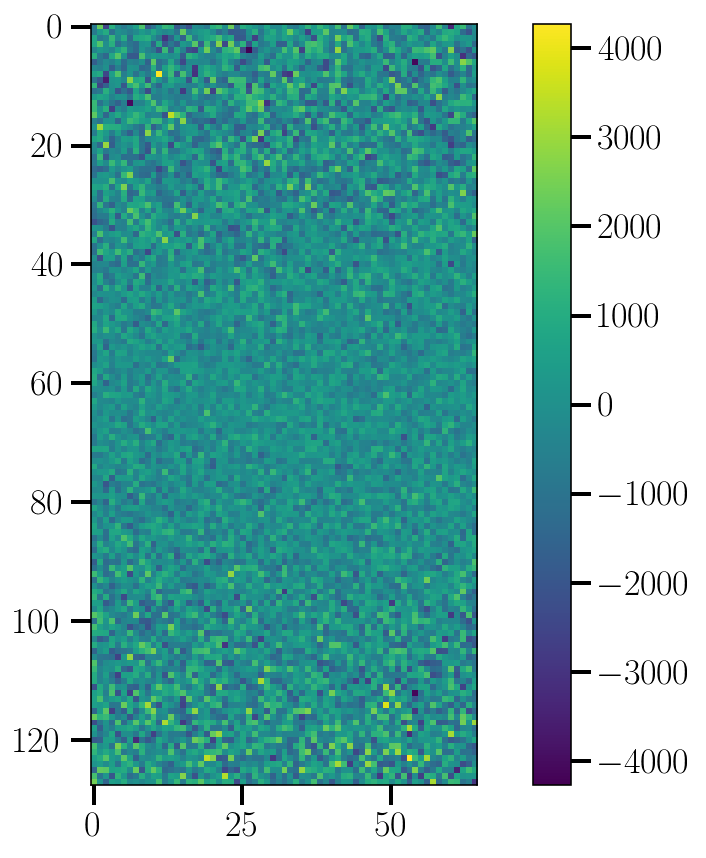

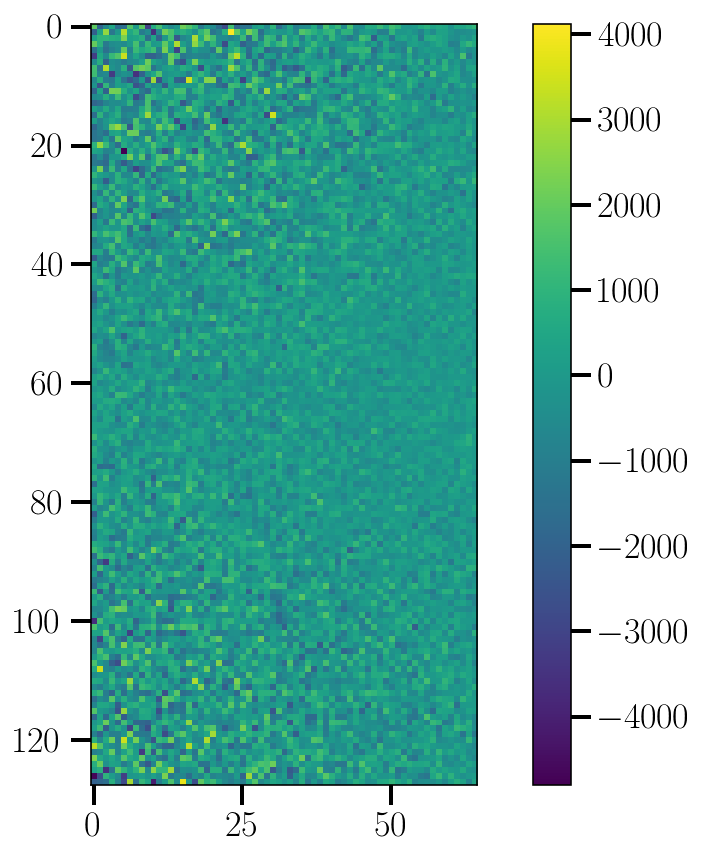

In [118]:
from matplotlib import colors
plt.figure(figsize=(10,7)) 
plt.imshow(class_pk1.FFTW_fft(gr_field)[80,:,:].real-class_pk1.FFTW_fft(gr_field2)[80,:,::-1].real)
plt.colorbar()
plt.show()
from matplotlib import colors
plt.figure(figsize=(10,7)) 
plt.imshow(class_pk1.FFTW_fft(gr_field2)[40,:,:].real)
plt.colorbar()
plt.show()

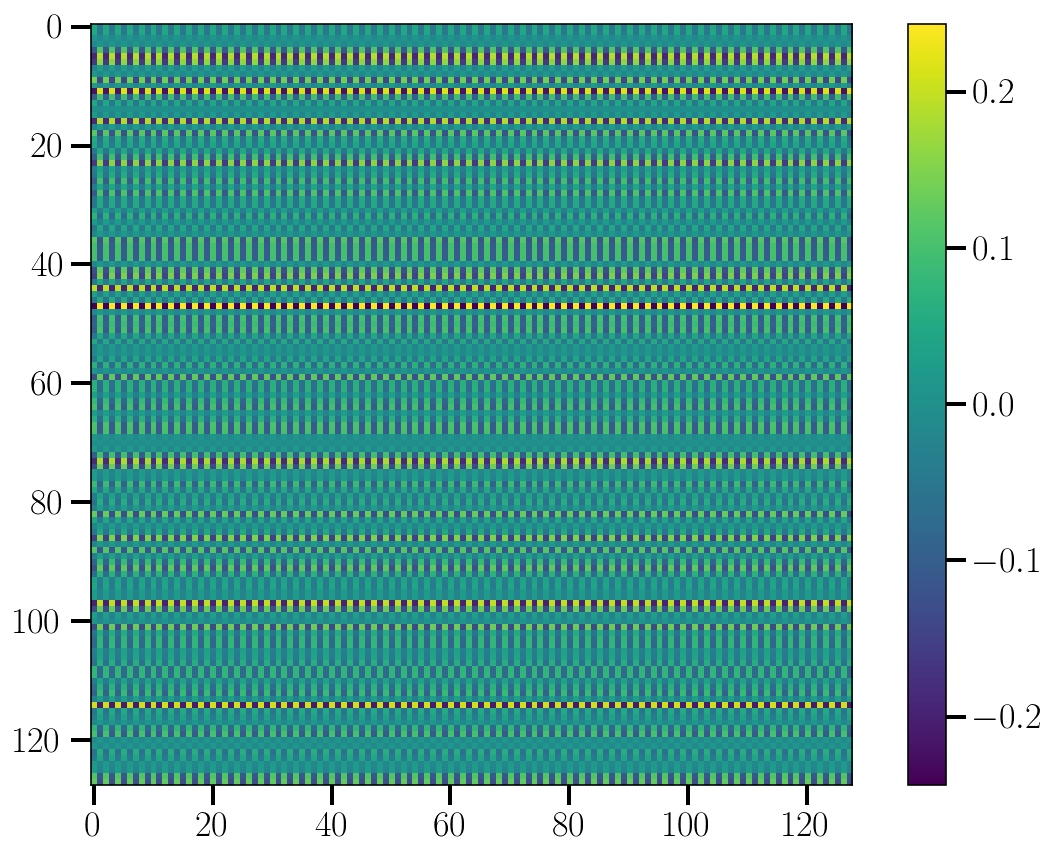

In [33]:
from matplotlib import colors
plt.figure(figsize=(10,7)) 
plt.imshow(field_mu[10,:,:].imag)
plt.colorbar()
plt.show()

In [34]:
print(field_mu.shape)

(128, 128, 128)


In [35]:
#dir(class_pk)

In [36]:
%%time

l=1
#get power_spectrum
Pk_ell = Pk.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,False,dtype,threads,rfft,verbose).pk
Pk_ell1 = Pk.Pk(gr_field,L,Nside,l,k_est,grid_info,binning_info,t,exorder,False,dtype,threads,rfft,verbose).pk

#Pk_ell1 = Pk_one.Pk(field_tmp,L,Nside,l,k_est,grid_info,binning_info,t,exorder,False,dtype,threads,rfft,verbose).pk

CPU times: user 2.11 s, sys: 74.1 ms, total: 2.18 s
Wall time: 1.56 s


In [132]:
l=1
pkl = class_pk.get_Pk(field_tmp,l,exorder,t)
pkl1 = class_pk1.get_Pk(field_tmp,l,exorder,t)

pkl_gr = class_pk.get_Pk(gr_field,l,exorder,t)
pkl1_gr = class_pk1.get_Pk(gr_field,l,exorder,t)

pk_mul = class_pk1.get_Pk(gr_field,l,exorder,t,delta2=field_tmp)
pk_mul1 = class_pk1.get_Pk(field_tmp,l,exorder,t,delta2=gr_field)


pk_flip = class_pk1.get_Pk(field_tmp,l,exorder,t,delta2=field_tmp2[:,:,::-1])
pk_flip_gr = class_pk1.get_Pk(gr_field,l,exorder,t,delta2=gr_field2[:,:,::-1])

/home/addis/PkBk/Library/FFTW.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  in_array[:] = delta


Text(0.5, 0, 'k')

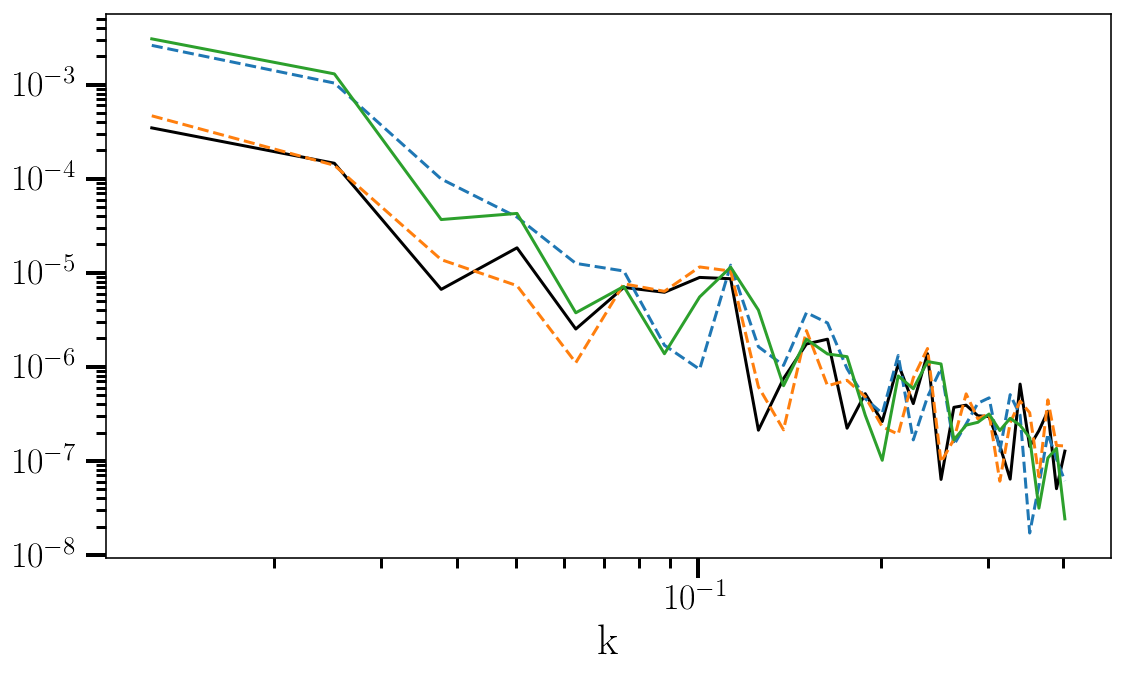

In [133]:
plt.figure(figsize=(9,5))

#plt.loglog(k_est,np.abs(Pk_ell.imag),'k')
plt.loglog(k_est,np.abs(pkl.imag),'-',color='k')
#plt.loglog(k_est,np.abs(pkl1.imag),'--',color='k')
#plt.loglog(k_est,np.abs(pkl.imag))
#plt.loglog(k_est,np.abs(pkl_gr.imag))


#plt.loglog(k_est,np.abs(pkl1_gr.imag))
#plt.loglog(k_est,np.abs(pkl1_gr.imag),'--')
plt.loglog(k_est,np.abs(pkl_gr.imag),'--')
#plt.loglog(k_est,np.abs(pkl_gr.imag))

#plt.plot(k_est,np.abs(pk_mul.imag),'.')
#plt.plot(k_est,np.abs(pk_mul1.imag),'|')

#plt.loglog(k_est,np.abs(Pk_ell1.real),'--')
plt.loglog(k_est,np.abs(pk_flip.imag),'--')
plt.loglog(k_est,np.abs(pk_flip_gr.imag),'-')
plt.xlabel('k')
 

# If you want to save results over realisations in dict...

In [119]:
#define empty dict to fill in...
pk = {
    'Cen' : {},#redshift space in centre
    '-500' : {},#z_obs
    '0':{},
    'PP' : {}, # PP with RSD
    'real': {}, #real space
    '-1000' : {},
    '250' : {},
    '0_other' : {},
    '-100' : {},
    '100' : {},
    '-250' : {},
    '400' : {},
    '-400' : {}
    } p

In [124]:
#this is designed
def pk_realisations(field,init_dict,ls,ts,exorder,obs_pos,N_min,N_max):#add path so choose fields as were
    """function to run to calculate bispectrum for different multiplles over realisations"""
    pk_dict= init_dict.copy()
    N_side=128
    L=1000
    rfft=False
    order=2
    #obs_pos=(500,500,z_obs)#
    grid_info = cgi.compute_survey(N_side,L,rfft,order,obs_pos)
    
    iFFT=False
    dtype=np.complex64
    threads=4
    verbose=True
    
    #s=1/2 #units of 2*k_f
    k_est = np.arange(grid_info[5],grid_info[6],2*s*grid_info[5]) + s*grid_info[5] #create k bins centers - from k_f to k_ny with steps of s*k_f
    binning_info = cgi.pk_compute_bins(k_est,s,grid_info[3],grid_info[5])
    #In_bin,N_modes 
    
    for t in ts:#which LOS
        for l in ls:  #which multipoles to calculate
            key_mono = 'l=%d'%(0)
            key ='l=%d'%(l) +',t=' + str(t)[-1]

            arr_pk = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64) #create empty arrays in dict to store bispectra
            arr_mono = np.zeros((N_max-N_min,len(k_est)),dtype=np.complex64)
            for i in tqdm(range(N_min,N_max)):
                realisation = str(10000 + i)
                                                            #
                field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + field+ '.npy') #load field
                j = Pk.Pk(field_tmp,L,N_side,l,k_est,grid_info,binning_info,t,exorder,iFFT,dtype,threads,rfft,verbose)

                arr_pk[i-N_min] = j.pk
                if l % 2 == 0:
                    arr_mono[i-N_min] = j.mono
            
            #for resets...
            if key in pk_dict.keys():
                if len(pk_dict[key]) >= N_max - N_min:#in case of error just delete
                    print('uhh')
                    pk_dict.pop(key, None)
                    pk_dict.pop(key_mono, None)
                
            if key in pk_dict.keys(): # create array with extra zeros beyond which has already been computed
                pk_dict[key] = np.concatenate((pk_dict[key][:N_min],arr_pk))
                if l % 2 == 0:#if even
                    pk_dict[key_mono] = np.concatenate((pk_dict[key_mono][:N_min],arr_mono))
            else:
                pk_dict[key] = arr_pk 
                if l % 2 == 0:
                    pk_dict[key_mono] = arr_mono
                 
    return pk_dict

ls= [1]#
ts = [0]#

exorder = 0

obs_pos = (500,500,-1e+10)

field = 'real'#str(obs_pos[-1]) #'Cen' #'PP'#'Cen'#'0_other'#'000'# 'real'#
field_add = '_LOS='+field
if field == 'real': #real has a different naming convention for no reason
    field_add = ''
    
pk[field] = pk_realisations(field_add,pk[field],ls,ts,exorder,obs_pos,0,200)

100%|██████████| 200/200 [01:37<00:00,  2.06it/s]


In [125]:
#calculate avg and std of all realisations
def avg_err(Pk):#ok so adapt to nested dict structure...
    Pk_avg = {}
    Pk_err = {}
    Pk_std = {}
    for i in Pk.keys():#so this loops over each type - i.e. PP,Cen,real_space
        Pk_avg[i] = {}#create the nested dictionary to fill...
        Pk_err[i] = {}
        Pk_std[i] = {}
        for j in Pk[i].keys(): # loop over multipole keys - to get mean and std for each
            Pk_avg[i][j] = np.mean((Pk[i][j]),axis=0)
            Pk_err[i][j] = np.std(Pk[i][j],axis=0)/np.sqrt(len(Pk[i][j])) # standard error makes sense as we have independent realisations
            Pk_std[i][j] = np.std(Pk[i][j],axis=0)
    return Pk_avg,Pk_err,Pk_std

Pk_avg,Pk_err,Pk_std = avg_err(pk)
#Pk_avg1,Pk_err1,Pk_std1 = avg_err(pk1)

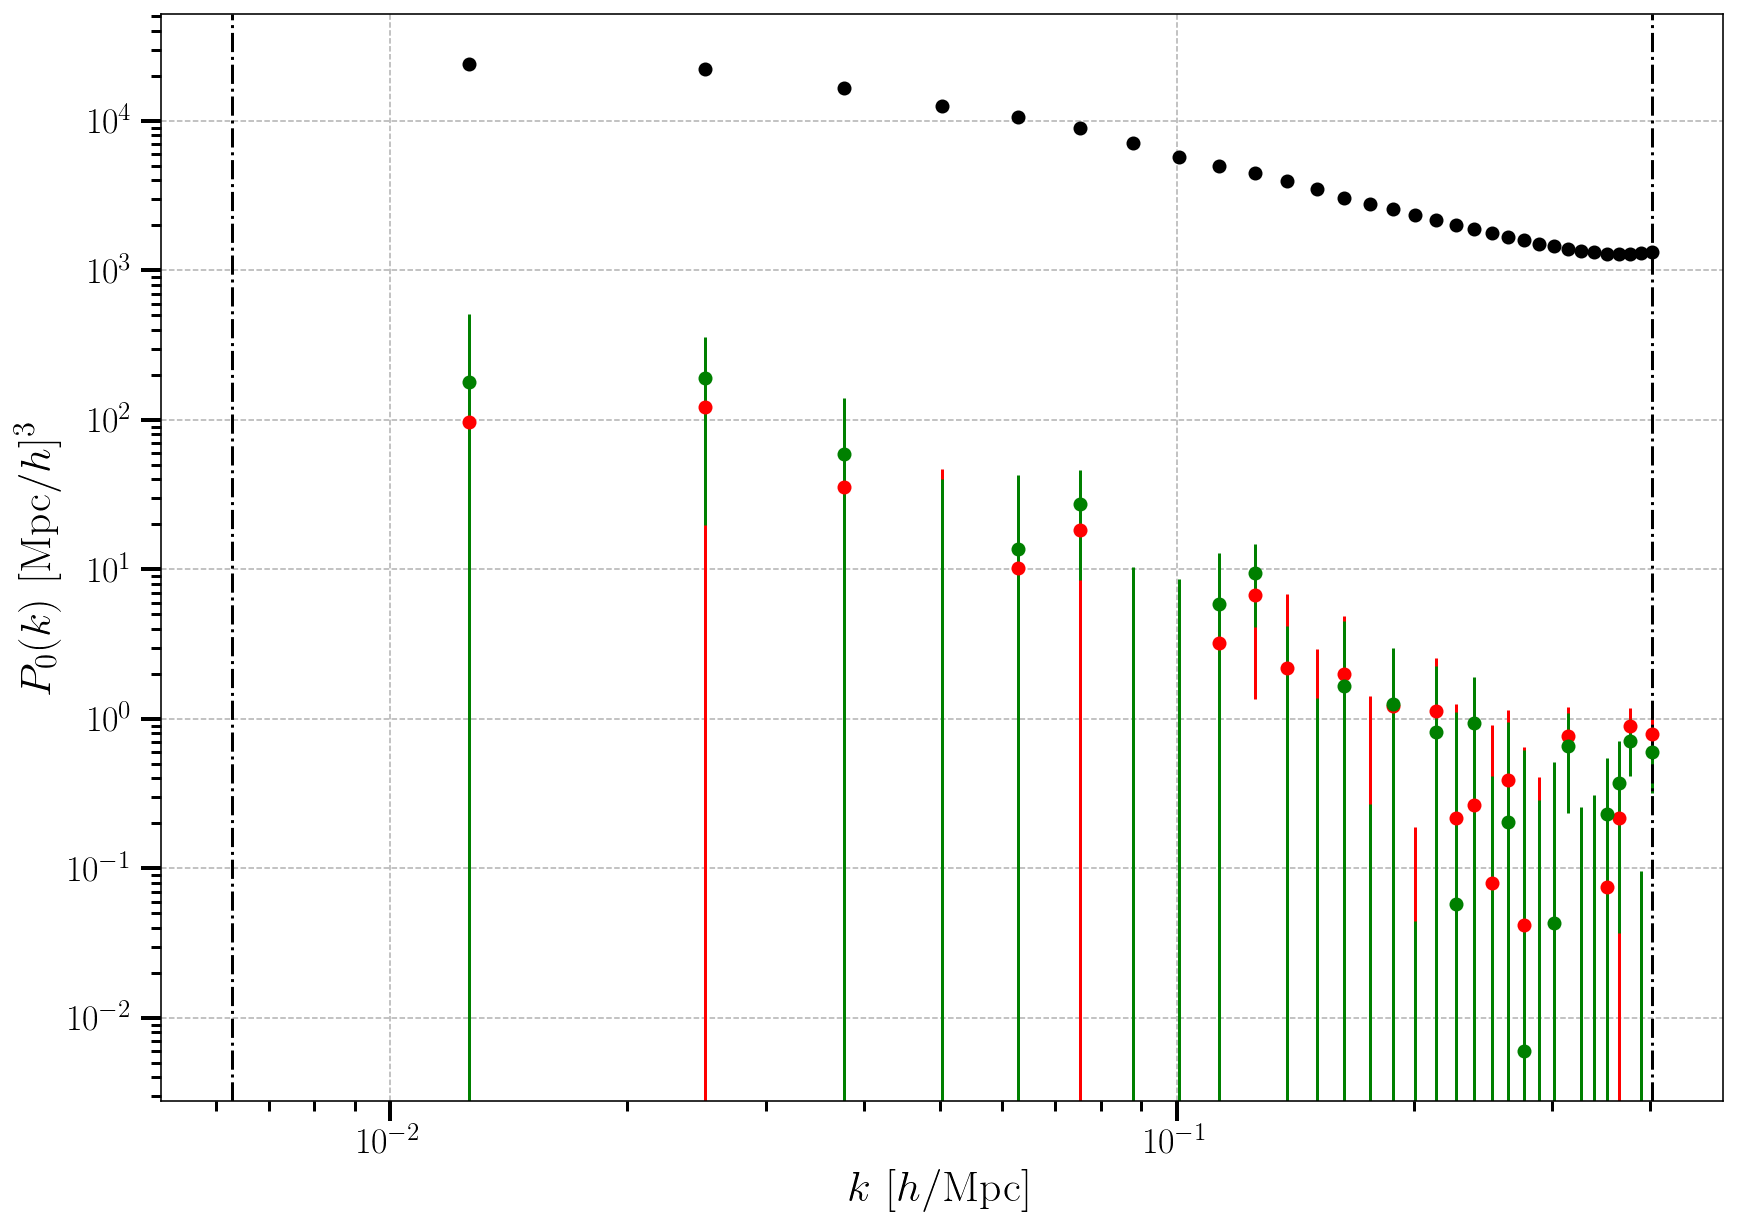

In [164]:
#monopole!!!
plt.figure(figsize=(14,10))

#plt.errorbar(k_est,np.abs(Pk_avg['0']['l=0'].real),yerr=Pk_err['0']['l=0'],fmt ='o',color='blue')
#
plt.errorbar(k_est,(Pk_avg['real']['l=0'].real),yerr=Pk_err['PP']['l=0'],fmt ='o',color='black')
plt.errorbar(k_est,(Pk_avg1['real']['l=0'].real),yerr=Pk_err1['PP']['l=0'],fmt ='o',color='red')
plt.errorbar(k_est,(Pk_avg1['PP']['l=0'].real),yerr=Pk_err1['PP']['l=0'],fmt ='o',color='green')

#plt.loglog(ks,Pl0_pp,'-',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
#plt.plot(ks,pk_mono_dfog(ks,4)+pk_mono_dfog_wa(ks,4,430,0),'-.')

plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
#plt.xlim(5e-3,0.5e0)
#plt.ylim(3e+3,5e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{0}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
plt.yscale('log')

plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

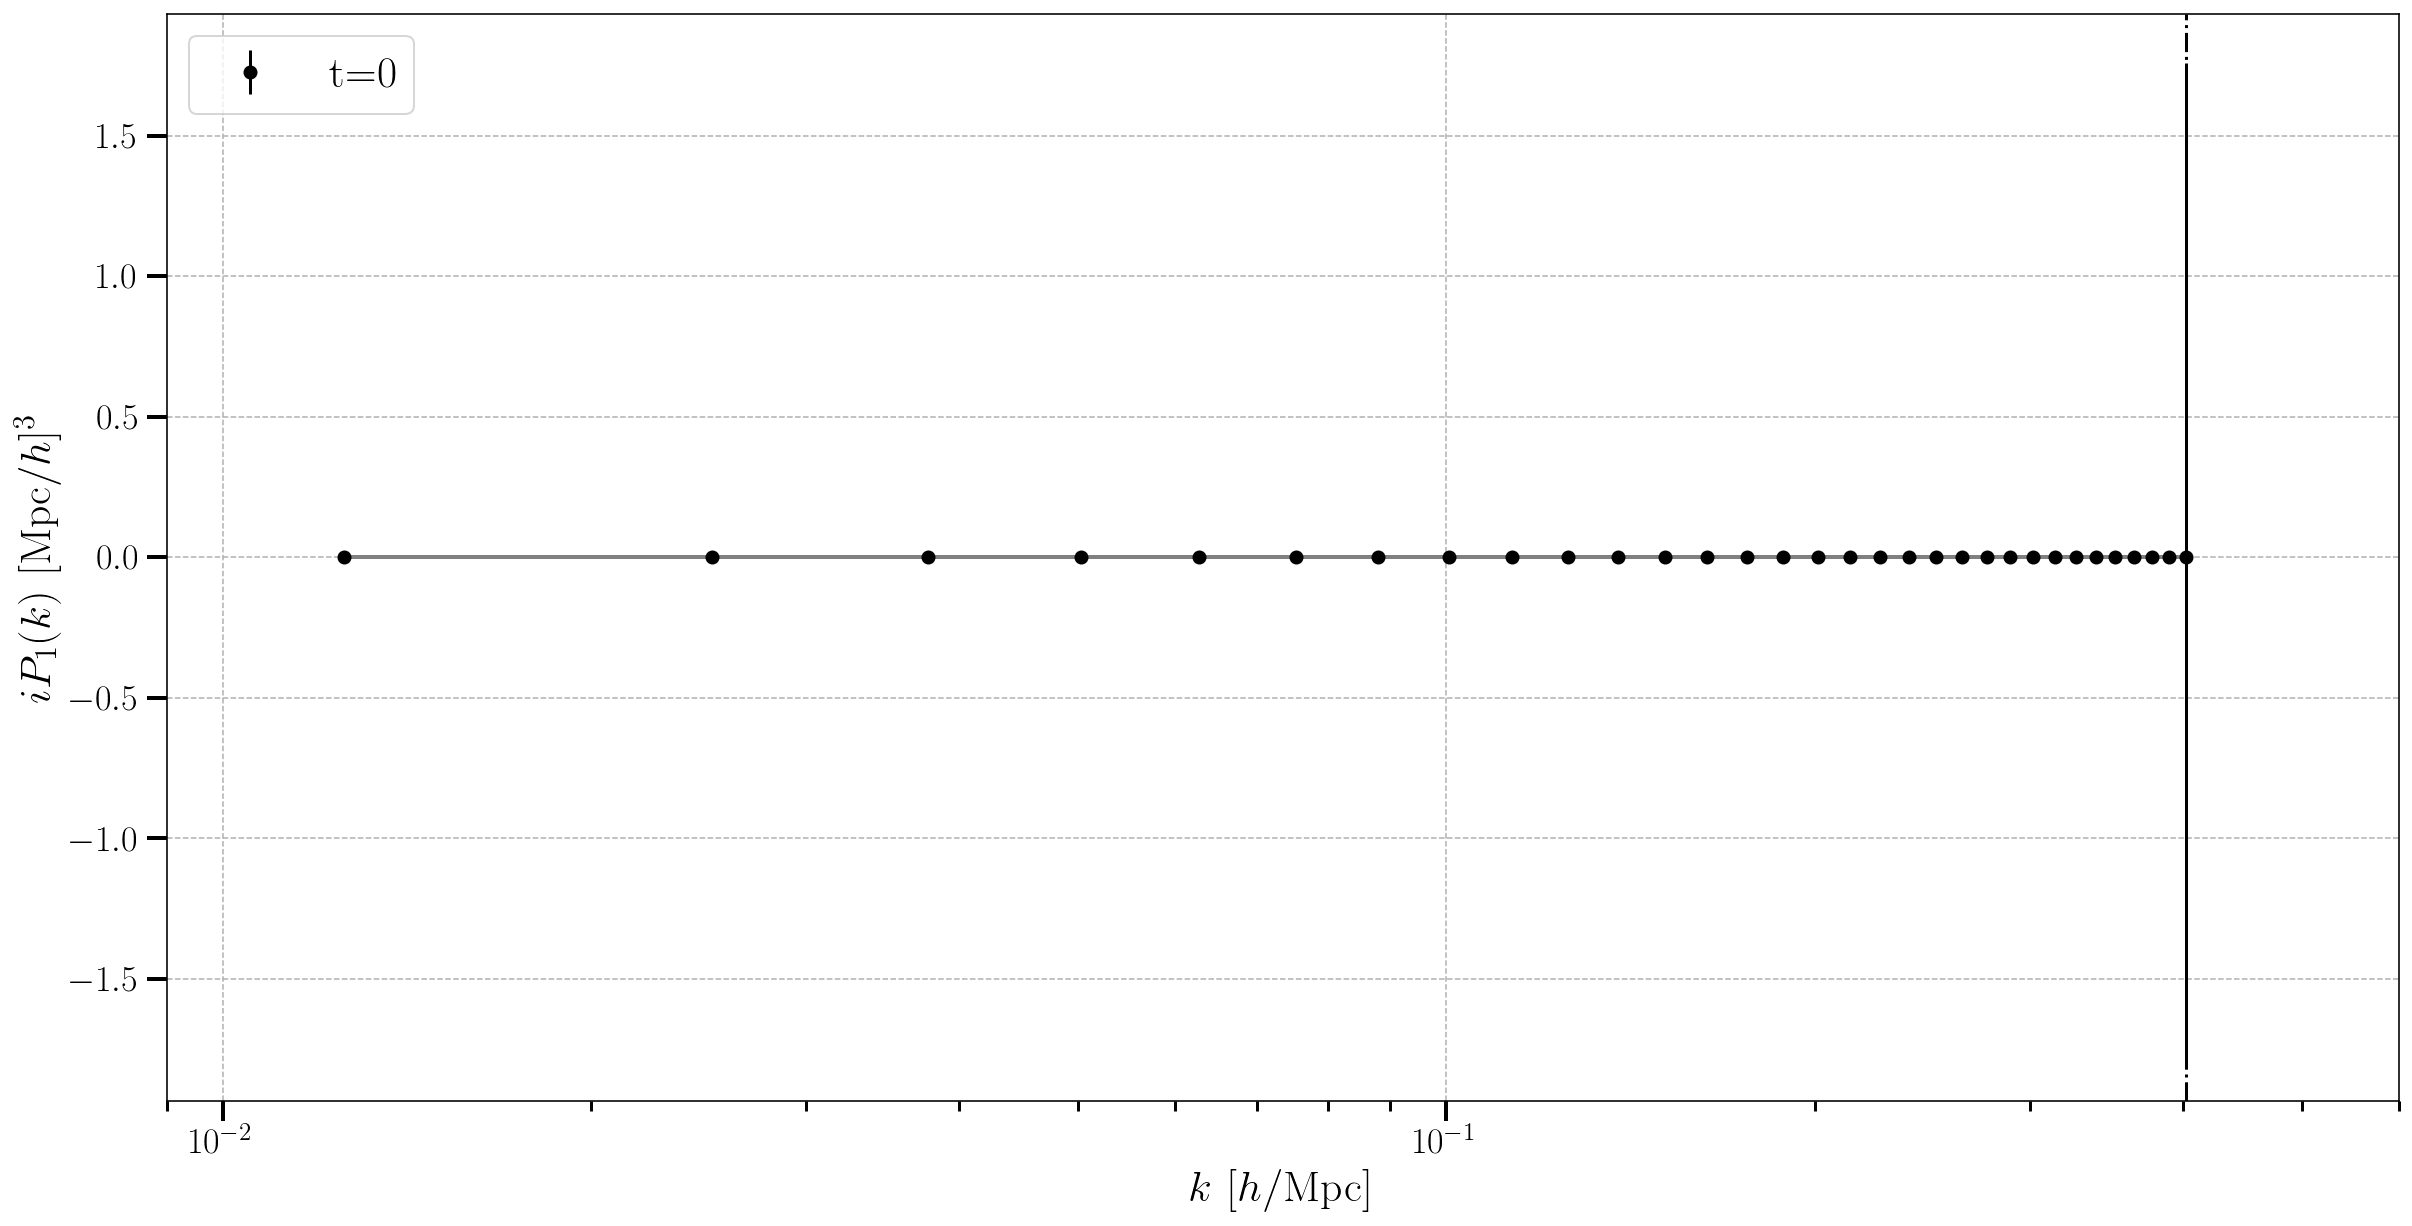

In [199]:
#dipole!!!
plt.figure(figsize=(20,10))
key ='real'

plt.errorbar(k_est,(Pk_avg[key]['l=1,t=0'].imag),yerr=Pk_std[key]['l=1,t=0'],fmt ='o',linestyle='none',color='black',label='t=0')

#plt.errorbar(k_est,(Pk_avg1[key]['l=1,t=0'].imag),yerr=Pk_err1[key]['l=1,t=0'],fmt ='o',linestyle='none',color='red',label='t=0')
#plt.errorbar(k_est,(Pk_avg1['PP']['l=1,t=0'].imag),yerr=Pk_err1['PP']['l=1,t=0'],fmt ='o',linestyle='none',color='blue',label='t=0')


for i in range(100):
    plt.plot(k_est,-(pk[key]['l=1,t=0'][i].imag),'-',alpha=0.6,color='grey')

#plt.plot(ks, -ks**2 *(pk_dipo_dfog_wa(ks,5.3,420,0).imag+pk_dipo_3(ks,250,0).imag),color='blue',linestyle='-.')
#plt.plot(ks, -ks**2 *(pk_dipo_dfog_wa(ks,5.3,420,0).imag),color='black',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(9e-3,0.6e0)
#plt.ylim(-1e+2,1e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()

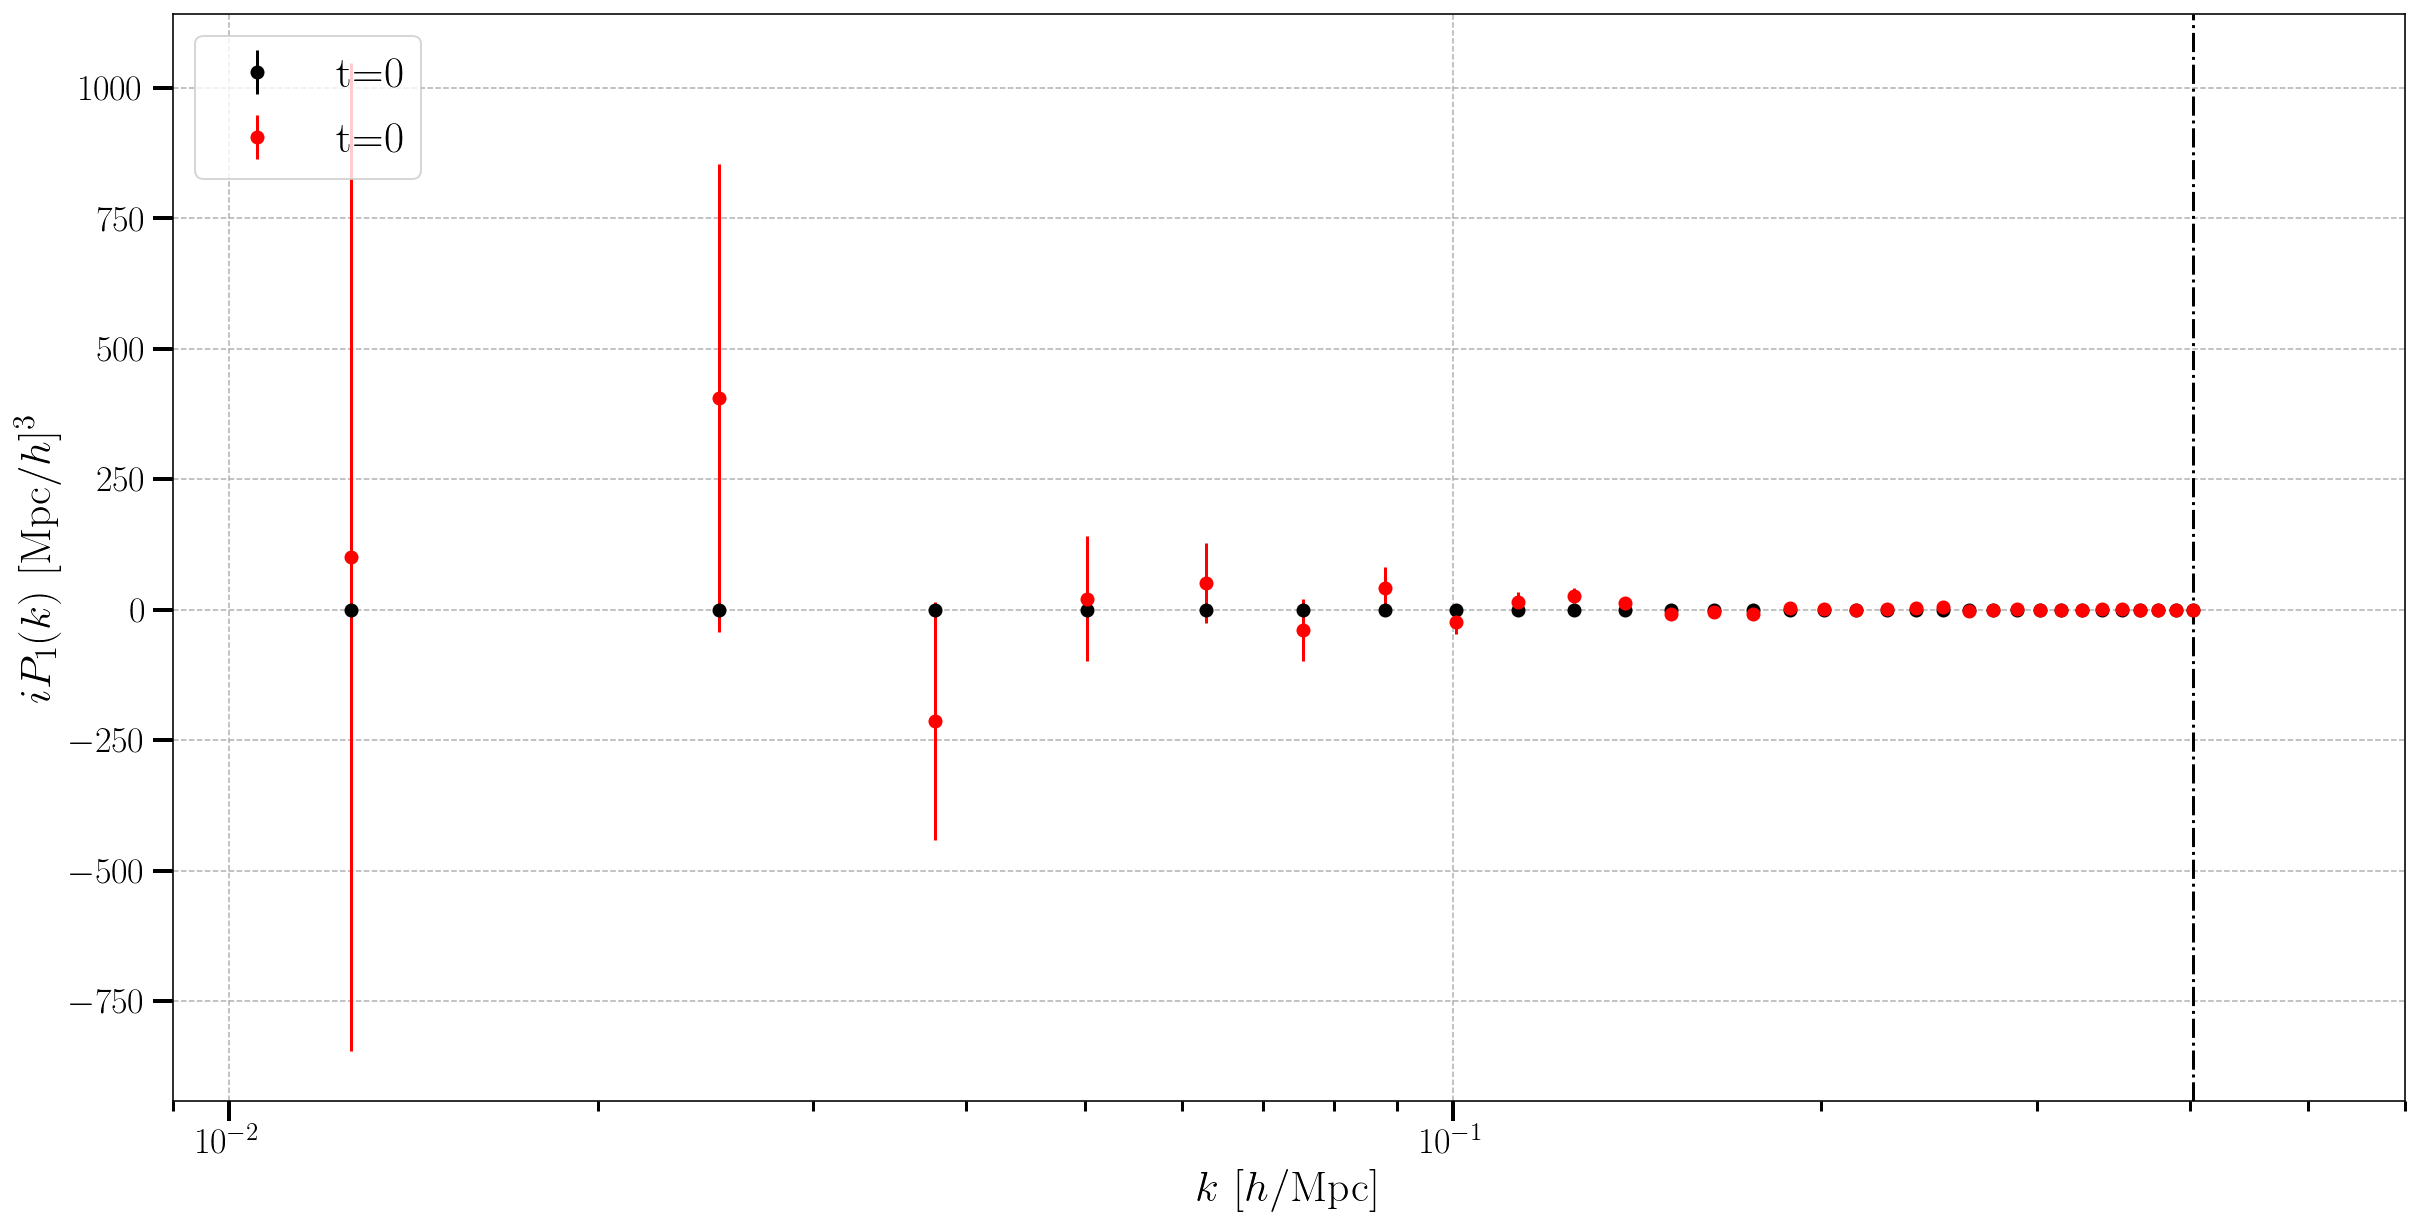

In [98]:
#dipole!!!
plt.figure(figsize=(20,10))
key ='PP'

plt.errorbar(k_est,(Pk_avg[key]['l=1,t=0'].imag),yerr=Pk_err[key]['l=1,t=0'],fmt ='o',linestyle='none',color='black',label='t=0')
plt.errorbar(k_est,(Pk_avg1[key]['l=1,t=0'].imag),yerr=Pk_err1[key]['l=1,t=0'],fmt ='o',linestyle='none',color='red',label='t=0')


for i in range(400):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')

#plt.plot(ks, -ks**2 *(pk_dipo_dfog_wa(ks,5.3,420,0).imag+pk_dipo_3(ks,250,0).imag),color='blue',linestyle='-.')
#plt.plot(ks, -ks**2 *(pk_dipo_dfog_wa(ks,5.3,420,0).imag),color='black',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(9e-3,0.6e0)
#plt.ylim(-1e+2,1e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{1}(k)\,\,[\mathrm{Mpc}/h]^3$')
#plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.grid(ls='--',lw=0.75)
plt.show()

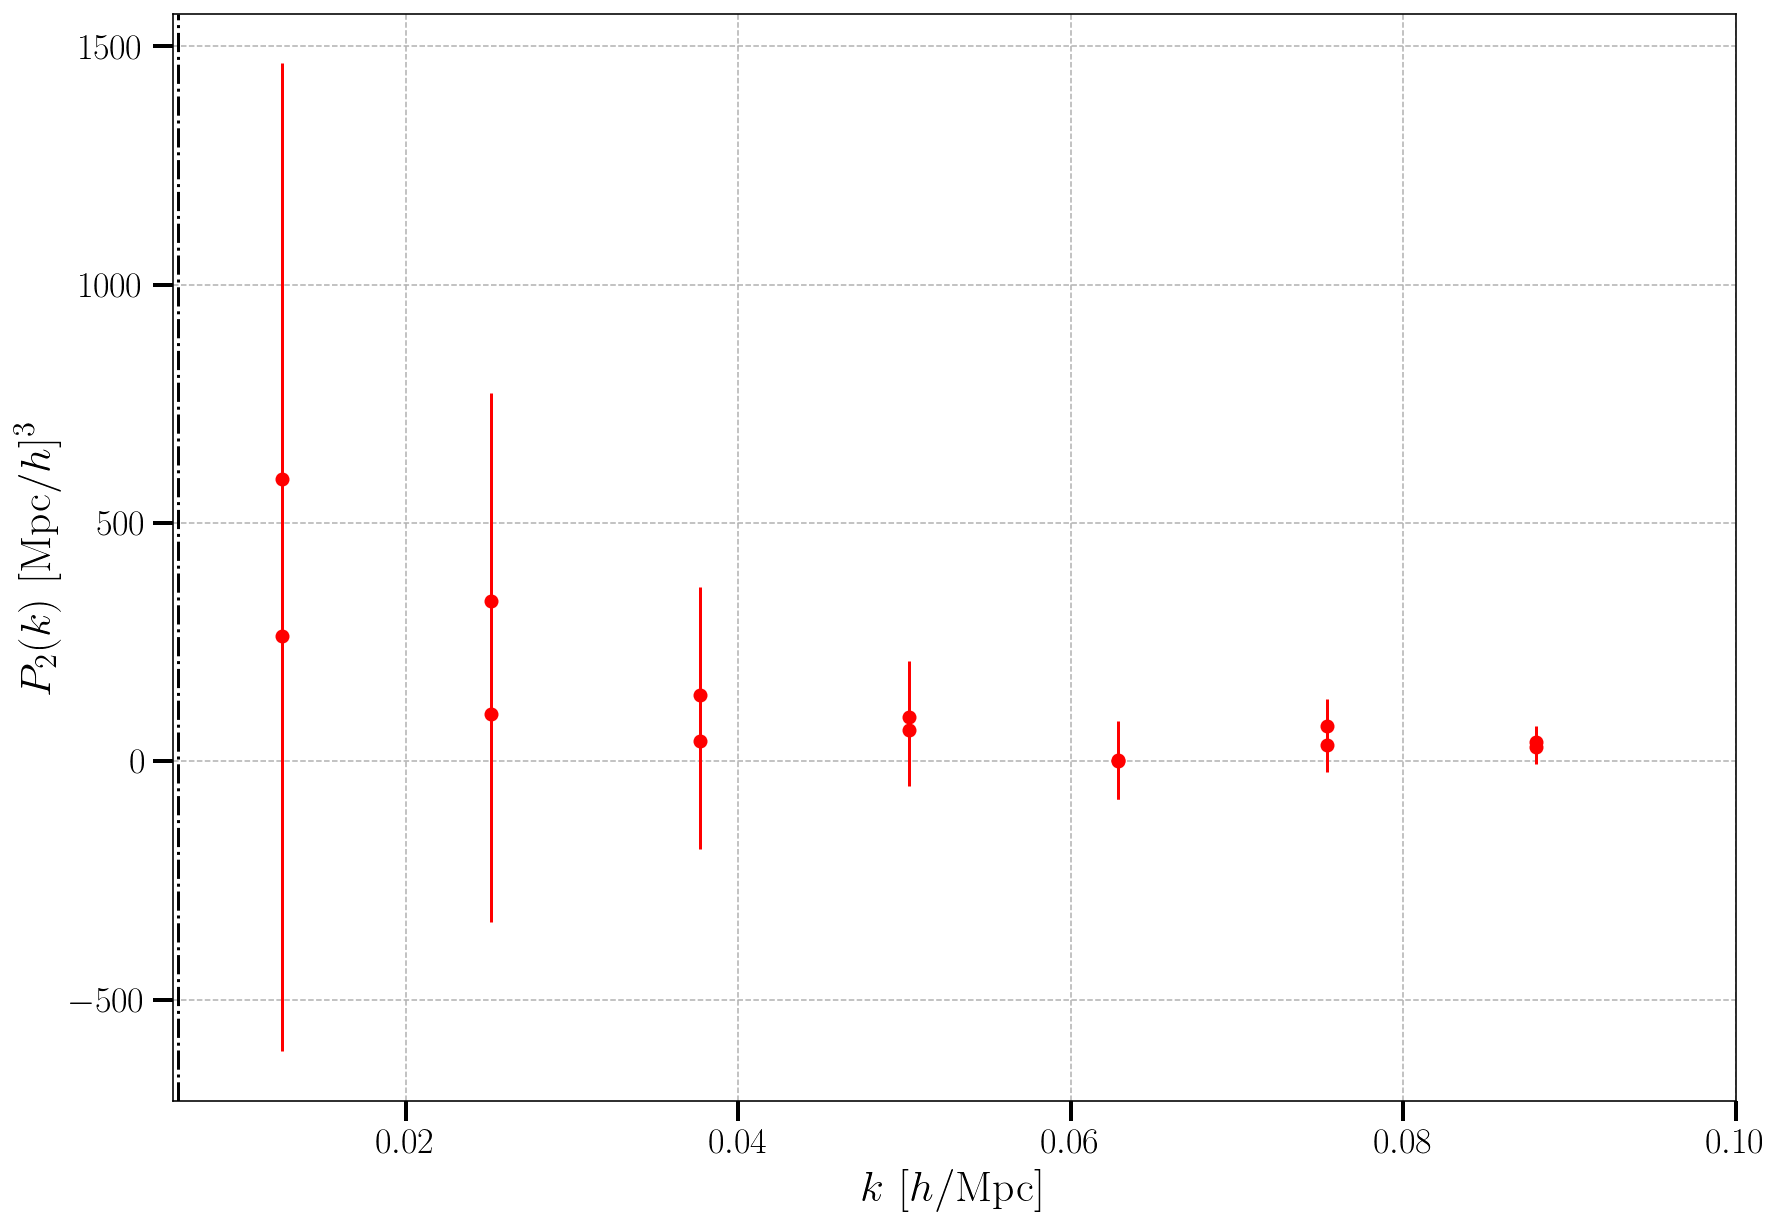

In [173]:
#quadrupole
plt.figure(figsize=(14,10))

#plt.errorbar(k_est,np.abs(Pk_avg['PP']['l=2,t=0'].real),yerr=Pk_err['PP']['l=2,t=0'],fmt ='o',color='black')
plt.errorbar(k_est,np.abs(Pk_avg1['PP']['l=2,t=0'].real),yerr=Pk_err1['PP']['l=2,t=0'],fmt ='o',color='red')
plt.errorbar(k_est,np.abs(Pk_avg1['real']['l=2,t=0'].real),yerr=Pk_err1['PP']['l=2,t=0'],fmt ='o',color='red')


#plt.plot(ks, pk_quad_dfog(ks,5.3),color='black')
#plt.plot(ks, pk_quad_dfog(ks,5.3)+pk_quad_dfog_wa(ks,5.3,500,0),color='black',linestyle='--')
#
#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=5'][i].real)),'.',alpha=0.2,color='blue')
    1#plt.loglog(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
#plt.ylim(3e+3,3e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$P_{2}(k)\,\,[\mathrm{Mpc}/h]^3$')
#plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

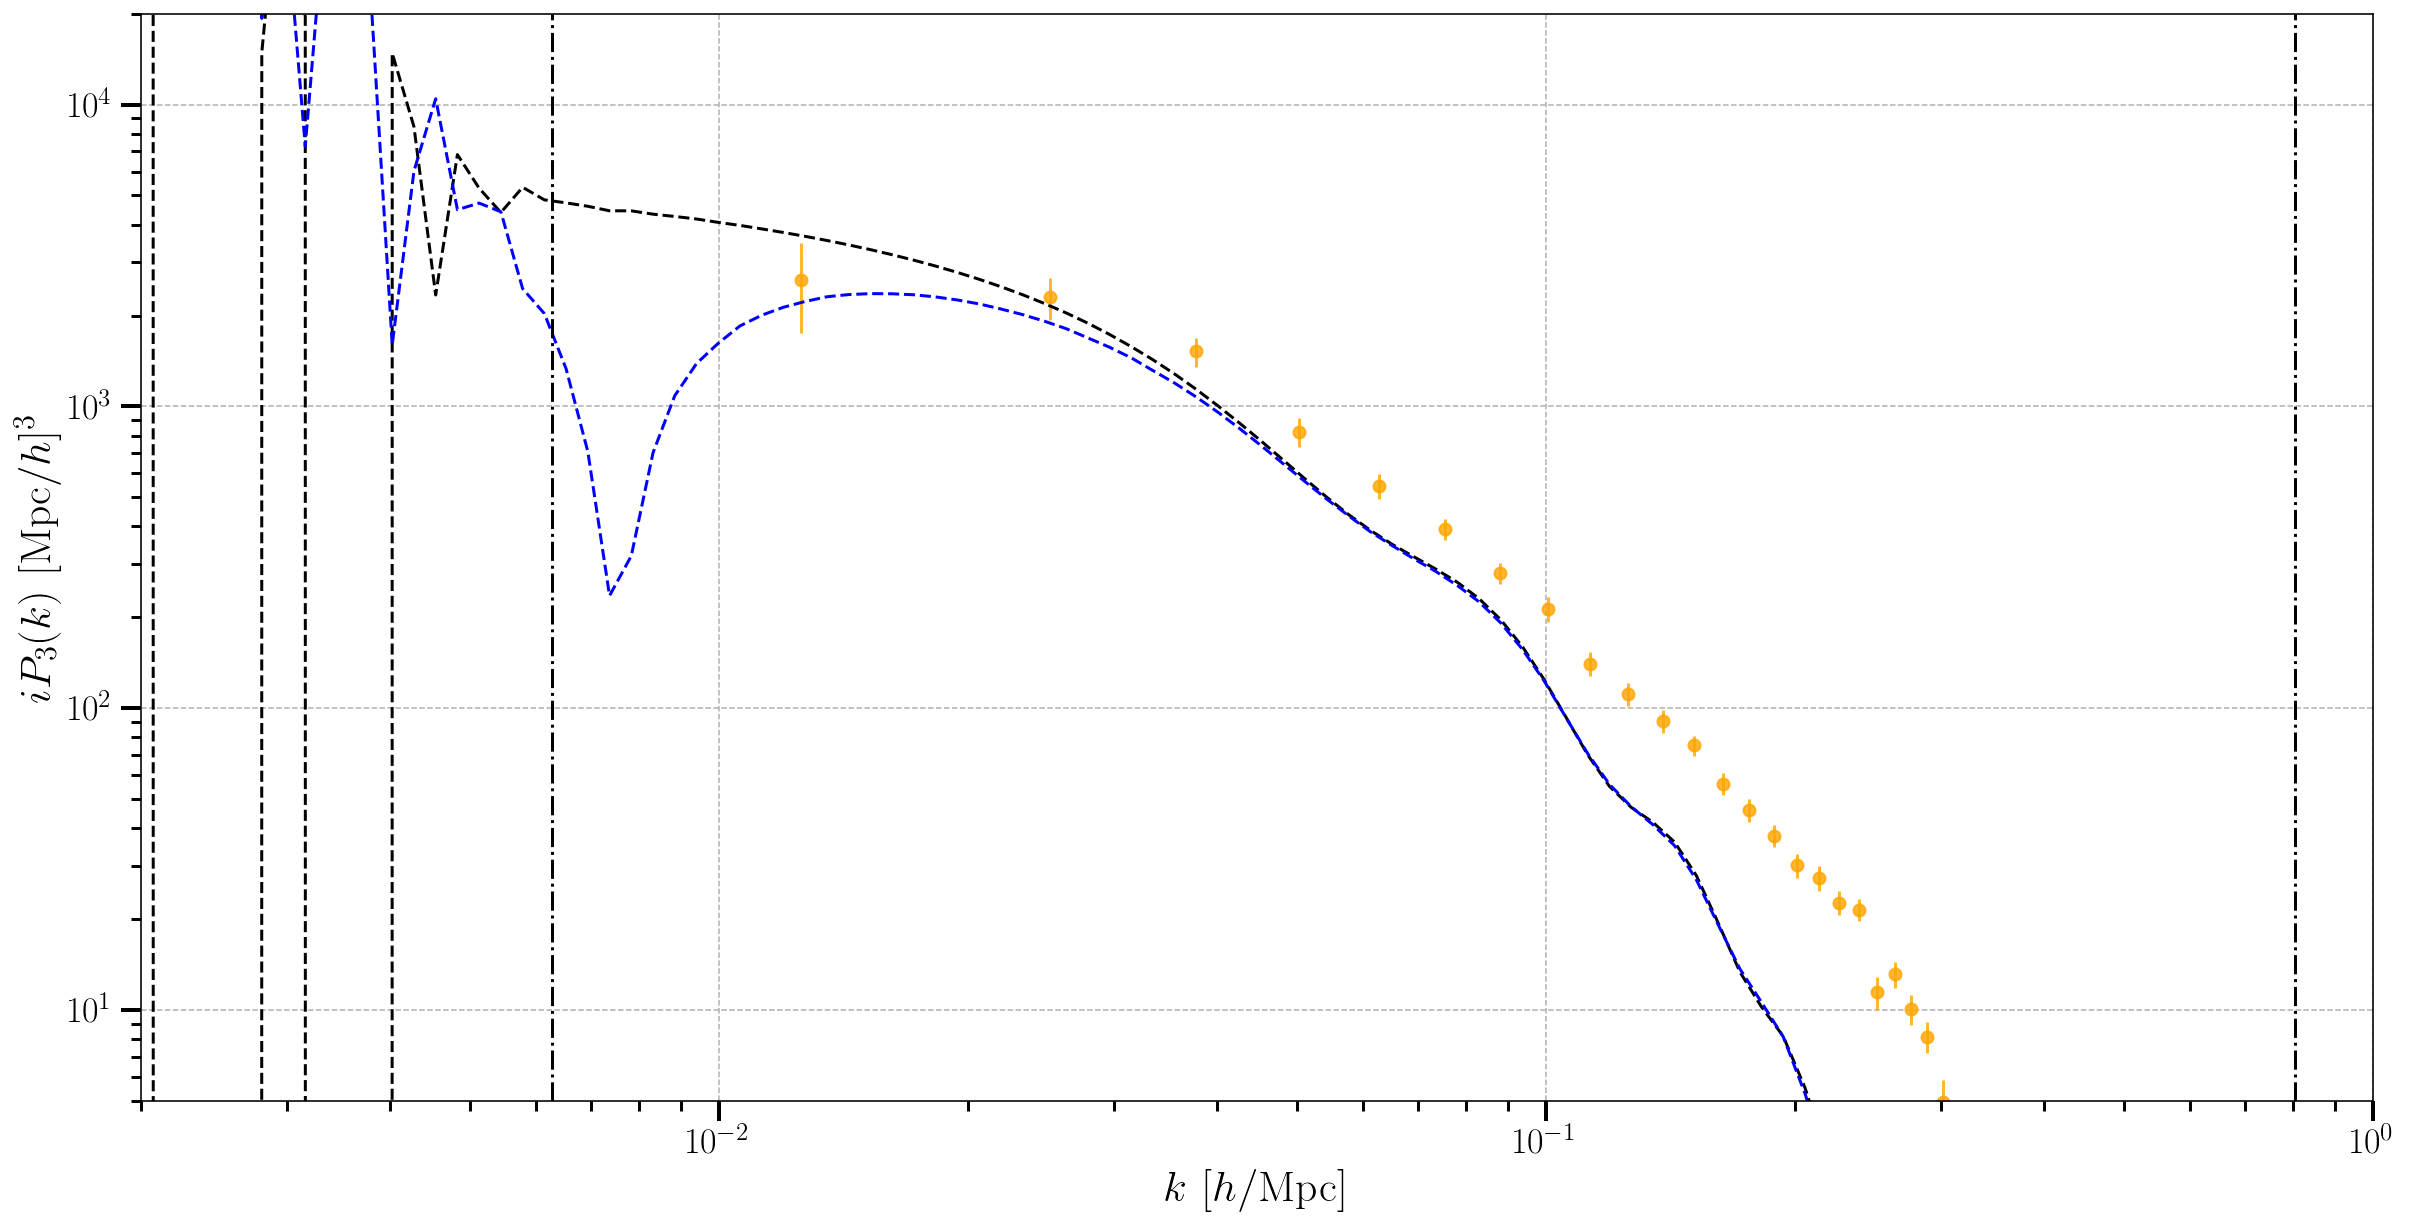

In [1063]:
#octupole!!!
plt.figure(figsize=(20,10))

key1 = '-100'
plt.errorbar(k_est,-(Pk_avg[key1]['l=3,t=0']).imag,yerr=Pk_err[key1]['l=3,t=0'],fmt ='o',linestyle='none',color='orange',alpha=0.8)

for i in range(100):
    1#plt.plot(k_est,-(pk['0']['l=1,t=0'][i].imag),'.',alpha=0.6,color='grey')

#plt.plot(ks,-(pk_oct(ks,d,0).imag+pk_octo_3(ks,d,0).imag),color='blue',linestyle='--')
plt.plot(ks,-(pk_octo_dfog_wa(ks,5.3,640,0).imag),color='black',linestyle='--')
plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,5.3,640,0).imag+pk_octo_3(ks,520,0).imag),color='blue',linestyle='--')

plt.axvline(x = grid_info[5], linestyle = '-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle = '-.', color = 'black')
plt.xlim(2e-3,1e0)
plt.ylim(0.5e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$i P_{3}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.yscale('log')
plt.xscale('log')
plt.grid(ls='--',lw=0.75)
plt.savefig("P_0_pp_comp.png",bbox_inches='tight')#

In [985]:
print(pk['PP'].keys())

dict_keys(['l=1,t=0'])


In [1051]:
def slice_realisations(key,key1,low,high):
    temp_arr = 1*pk[key][key1]
    pk1[key][key1] = temp_arr[low:high]#this the way to change without chopping og
    print(pk1[key][key1].shape)
    return avg_err(pk1)

Pk_avg1,Pk_err1,Pk_std1 = slice_realisations('PP','l=2,t=0',0,400)
Pk_avg2,Pk_err2,Pk_std2 = slice_realisations('0','l=2,t=0',350,400)
print(pk['PP']['l=2,t=0'].shape)


(400, 32)
(50, 32)
(500, 32)


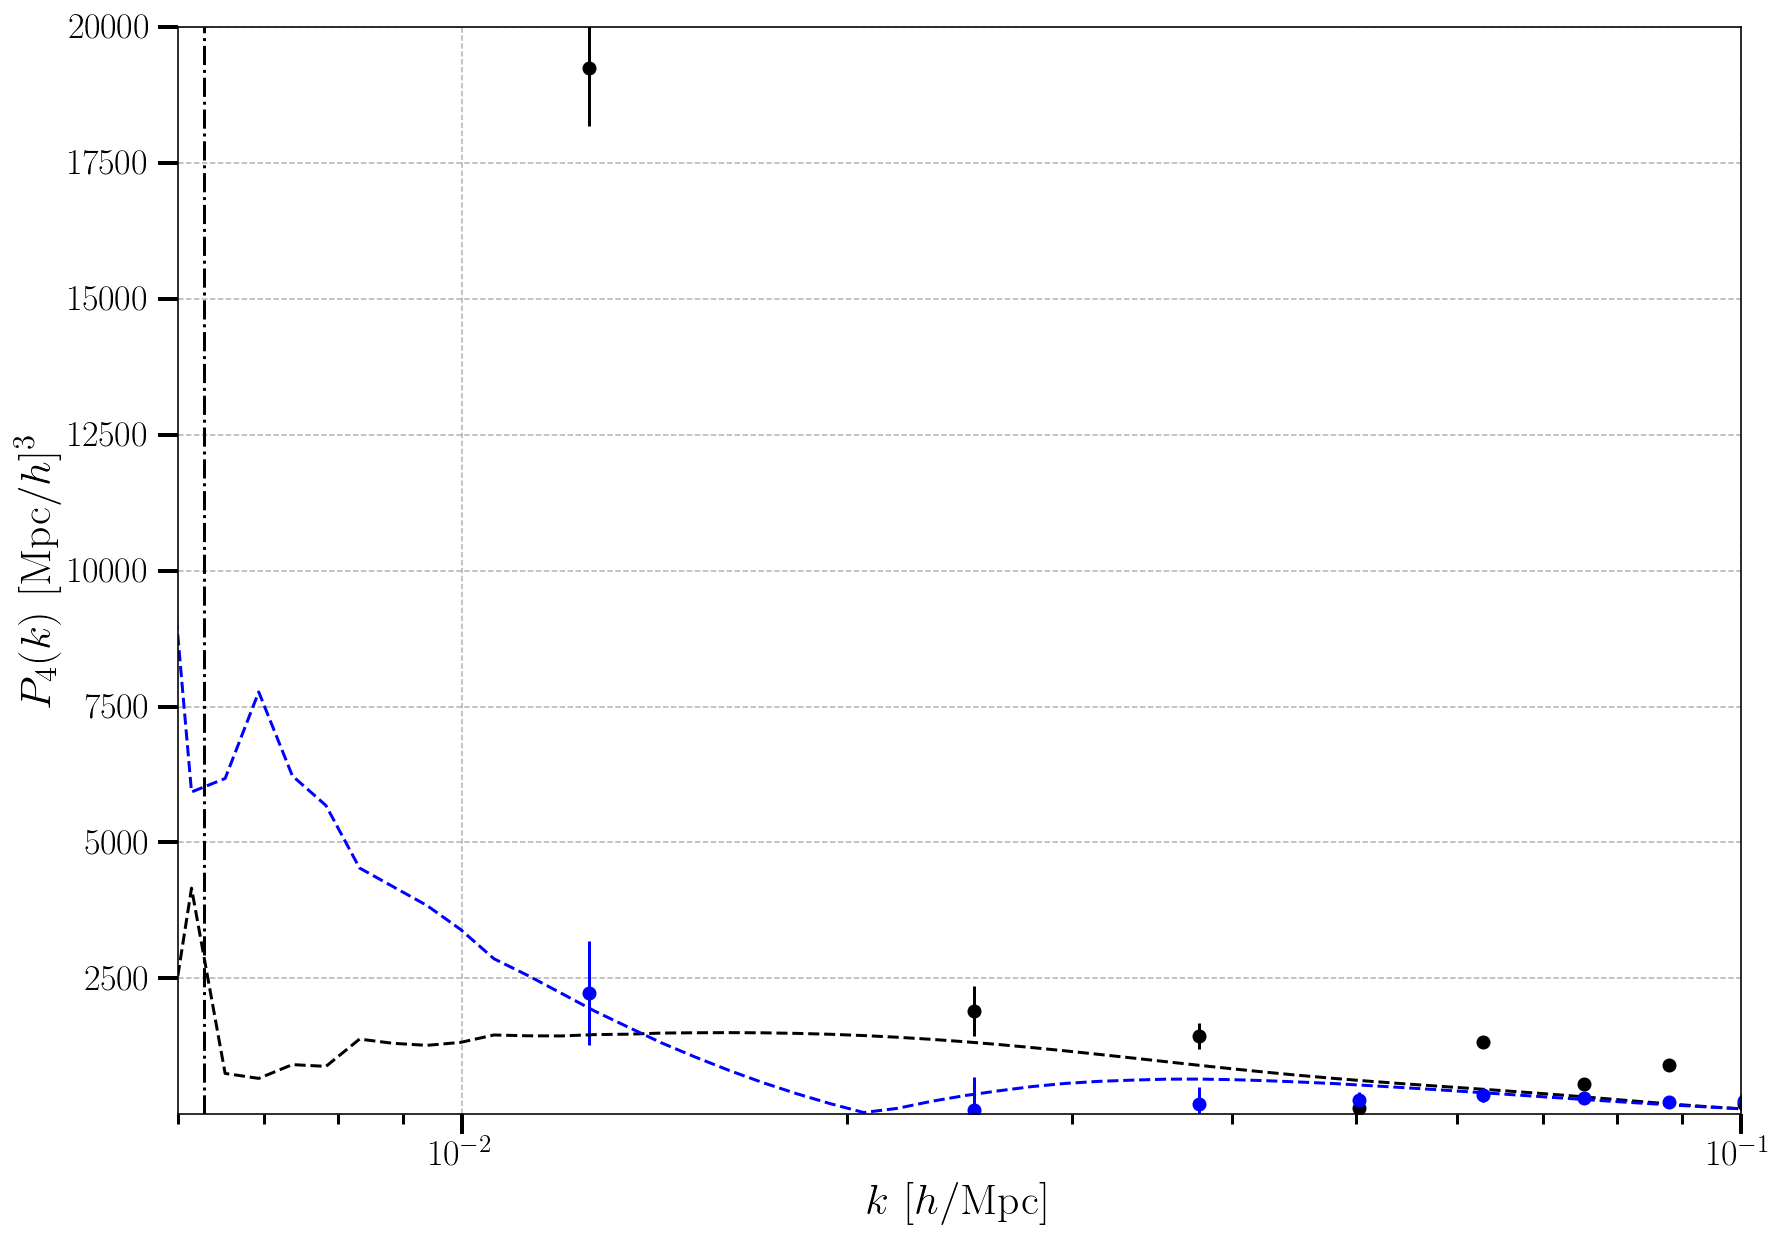

In [589]:
#hexadecapole
plt.figure(figsize=(14,10))

plt.errorbar(k_est,np.abs(Pk_avg['PP']['l=4,t=0'].real),yerr=Pk_err['PP']['l=4,t=0'],fmt ='o',color='black')
#plt.errorbar(k_est,np.abs(Pk_avg['-1000']['l=4,t=0'].real),yerr=Pk_err['-1000']['l=4,t=0'],fmt ='o',color='red')
plt.errorbar(k_est,np.abs(Pk_avg['Cen']['l=4,t=0'].real),yerr=Pk_err['Cen']['l=4,t=0'],fmt ='o',color='blue')

sigma=4
#plt.plot(ks, Pl4_pp,color='black')
plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)),linestyle='--',color='black')
plt.plot(ks, np.abs(pk_hexa_dfog(ks,sigma)+pk_quad_dfog_wa(ks,sigma,430,0)),linestyle='--',color='blue')
#plt.loglog(ks,Pl2_pp,'--',color='black')
for i in range(100):
    1#plt.plot(k_est,-(pk['PP']['l=4,t=0'][i].real),'.',alpha=0.2,color='blue')
    1#plt.plot(k_est,(np.abs(pk_500['l=2,t=0'][i].real)),'.',alpha=0.2,color='red')


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')
plt.xlim(6e-3,0.1e0)
plt.ylim(1e+1,2e+4)
plt.xlabel('$k\,\,[h/\mathrm{Mpc}]$')
plt.ylabel('$ P_{4}(k)\,\,[\mathrm{Mpc}/h]^3$')

plt.xscale('log')
#plt.yscale('log')

plt.grid(ls='--',lw=0.75)
#plt.savefig("P_0_pp_comp.png",bbox_inches='tight')

In [739]:
%%time
import sys
sys.path.append('/home/addis/Pylians3/library/build/lib.linux-x86_64-3.8')
import Pk_library as PKL
BoxSize = 1000.0 #Mpc/h
axis    = 2
MAS     = 'CIC'
threads = 4
realisation = str(10002)
field_tmp = np.load(path + 'fields_CIC/' + realisation + '_' + red_info + '_' + str(N_side) + '_LOS=PP' +'.npy')
Pk_py = PKL.Pk(np.array(field_tmp,dtype=np.float32), L, axis, MAS, threads, True)


Computing power spectrum of the field...
Time to complete loop = 0.12
Time taken = 0.13 seconds
CPU times: user 484 ms, sys: 18.1 ms, total: 502 ms
Wall time: 137 ms


In [740]:
k_py   = Pk_py.k3D
Pk0     = Pk_py.Pk[:,0] #monopole
Pk2     = Pk_py.Pk[:,1] #quadrupole
Pk4     = Pk_py.Pk[:,2] #hexadecapole

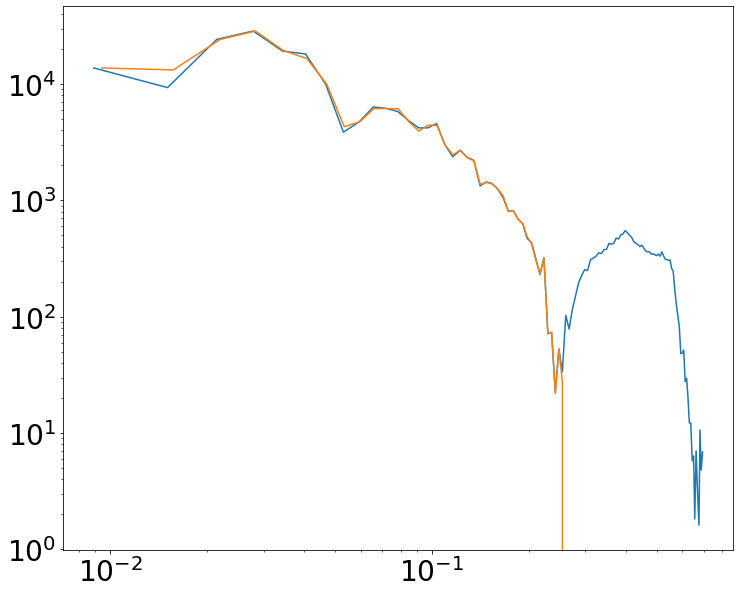

In [741]:
#pylians comparison
plt.figure(figsize=(12,10))
plt.loglog(k_py,np.abs(Pk2))
plt.loglog(k_est,pk['PP']['l=2,t=0'][2].real)

In [12]:
from classy import Class
z= 0
#Start by specifying the cosmology - fiducial quijote...
Omega_b = 0.049#0.05
Omega_m = 0.3175
Omega_l = 0.682
Omega_cdm = Omega_m - Omega_b
h = 0.6711#0.7 #H0/100
A_s = 2.1e-9
n_s = 0.9624
a = 1/(1+z)
H  = 100.0*np.sqrt(Omega_m*(1.0+z)**3+Omega_l)*a #Value of H(z) in km/s/(Mpc/h)

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 10 #UNITS: 1/Mpc

params = {   'output':'mPk',
             'non linear':'halofit',
             'Omega_b':Omega_b,
             'Omega_cdm':Omega_cdm,
             'h':h,
             'A_s':A_s,
             'n_s':n_s,
             'P_k_max_1/Mpc':k_max,
             'z_max_pk':10. #Default value is 10
}
#Initialize the cosmology and compute everything
cosmo = Class()
cosmo.set(params)
cosmo.compute()

#Specify k and z
k = np.logspace(-5, np.log10(k_max), num=50000) #Mpc^-1
#z already specififed

#Call these for the nonlinear and linear matter power spectra
Pnonlin = np.array([cosmo.pk(ki, z) for ki in k])
Plin = np.array([cosmo.pk_lin(ki, z) for ki in k])

#NOTE: You will need to convert these to h/Mpc and (Mpc/h)^3
#to use in the toolkit. To do this you would do:
k /= h
Plin *= h**3
Pnonlin *= h**3

In [18]:
#ok so set a comoving distance of observation
#d = comoving_dist(z)
#set z ...
def get_class_powerspectrum(kk,zz): #h are needed to convert to 1/Mpc for k then convert pk back to (Mpc/h)^3
     
    return np.array([cosmo.pk_lin(ki, zz) for ki in kk*h])*h**3

def get_pkinfo_z(k,z):
    Plin = get_class_powerspectrum(k,z)
    Pk = interpolate.interp1d(k,Plin)#Plin
    Pk_d = interpolate.interp1d(k,np.gradient(Plin,k))#(k[1:]+k[:-1])/2,np.diff(Plin)/np.diff(k)
    Pk_dd = interpolate.interp1d(k,np.gradient(Pk_d(k),k))
    Pk_ddd = interpolate.interp1d(k,np.gradient(Pk_dd(k),k))
    return Pk,Pk_d,Pk_dd,Pk_ddd

#so set parameters...
Pk_,Pk_d,Pk_dd,Pk_ddd = get_pkinfo_z(k,z)


In [19]:
# Lambda CDM
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy import interpolate
LCDM = Class()
LCDM.compute()
print(LCDM.get_current_derived_parameters)
baLCDM = LCDM.get_background()
print(baLCDM.keys())
f_cl = baLCDM['gr.fac. f']
z_cl = baLCDM['z']
H_cl = baLCDM['H [1/Mpc]'];H = interp1d(z_cl,H_cl*(1/(1+z_cl))/h,kind='cubic') # now in h/Mpc!
xi_cl = baLCDM['comov. dist.']; comoving_dist = interp1d(z_cl,xi_cl*h,kind='cubic') # just use class background as quick
f_intp = interp1d(z_cl,f_cl,kind='cubic')#get f #omega_mz = Omega_m *(1+zt)**3 /(Omega_m *(1+zt)**3 + Omega_l)

<built-in method get_current_derived_parameters of classy.Class object at 0x55e86c9ecde0>
dict_keys(['z', 'proper time [Gyr]', 'conf. time [Mpc]', 'H [1/Mpc]', 'comov. dist.', 'ang.diam.dist.', 'lum. dist.', 'comov.snd.hrz.', '(.)rho_g', '(.)rho_b', '(.)rho_cdm', '(.)rho_lambda', '(.)rho_ur', '(.)rho_crit', '(.)rho_tot', '(.)p_tot', '(.)p_tot_prime', 'gr.fac. D', 'gr.fac. f'])


In [20]:


ks = np.geomspace(1e-3,4e-1,100)
f = f_intp(z)

Pks = Pk_(ks)
Pkd= Pk_d(ks)
Pkdd= Pk_dd(ks)

d=1000
b1 = 1
t=0

In [21]:
Pk_l0_wa = f*(Pks*(7*b1*(-25*s - t*(12*t - 12) + 4) + f*(175*s - t*(36*t - 36) - 68)) + ks*(Pkd*(-35*b1*(5*s + t*(4*t - 4)) + f*(175*s - t*(60*t - 60) - 48)) - 2*Pkdd*ks*(7*b1*(t*(2*t - 2) + 1) + f*(t*(6*t - 6) - 5))))/(105*d**2*ks**2)
Pk_l1_wa = -4*f*(3*Pks+ Pkd*ks)*(7*b1 + 3*f)*(2*t - 1)/(35*d*ks)
Pk_l2_wa = 2*f*(-Pks*(2*b1*(70*s + t*(66*t - 66) + 5) + f*(-35*s + t*(108*t - 108) + 40)) + ks*(Pkd*(b1*(70*s + t*(44*t - 44) - 6) + f*(35*s - t*(12*t - 12) - 6)) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)
Pk_l3_wa = -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

def pk_oct(ks,d,t):
    Pks= Pk_(ks)
    Pkd= Pk_d(ks)
    return -4*1j*f*(2*t - 1)*(Pkd*ks*(9*b1 + f) - Pks*(18*b1 + 22*f))/(45*d*ks)

Pl0_pp = b1**2 *Pks+ (2*b1*f*Pks)/3 + (f**2 *Pks)/5
Pl2_pp = (4*b1*f*Pks)/3 + (4*f**2 *Pks)/7
Pl4_pp = (8*f**2 *Pks)/35

In [22]:
#these are some multipoles without inverse distance terms
Pk_l0_wa1 = 2*f*(Pks*(-21*b1*(t*(2*t - 2) + 1) - 18*f*t*(t - 1) + f) + ks*(Pkd*(-35*b1*(t*(2*t - 2) + 1) + f*(-t*(30*t - 30) + 11)) + Pkdd*ks*(-7*b1*(t*(2*t - 2) + 1) + f*(-t*(6*t - 6) + 5))))/(105*d**2*ks**2)
Pk_l2_wa1 = 2*f*(-2*Pks*(33*b1*(t*(2*t - 2) + 1) + f*(t*(54*t - 54) + 13)) + ks*(2*Pkd*(22*b1*t*(t - 1) + 11*b1 - 6*f*t*(t - 1) + 4*f) + Pkdd*ks*(11*b1 + 3*f)*(t*(2*t - 2) + 1)))/(21*d**2*ks**2)


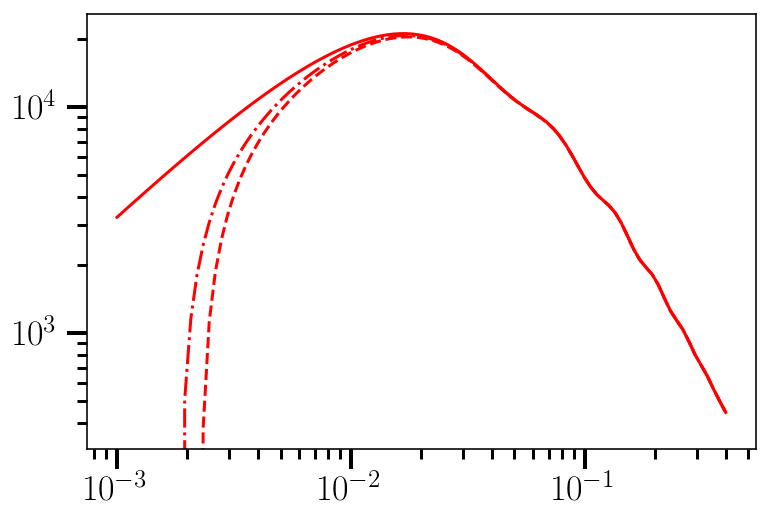

In [23]:
#plt.loglog(ks,Pl0_pp,color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa,'--',color='blue')
#plt.loglog(ks,Pl0_pp+Pk_l0_wa1,'-.',color='blue')
plt.loglog(ks,Pl2_pp,color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa,'--',color='red')
plt.loglog(ks,Pl2_pp+Pk_l2_wa1,'-.',color='red')
#plt.loglog(ks,Pk_l1_wa)

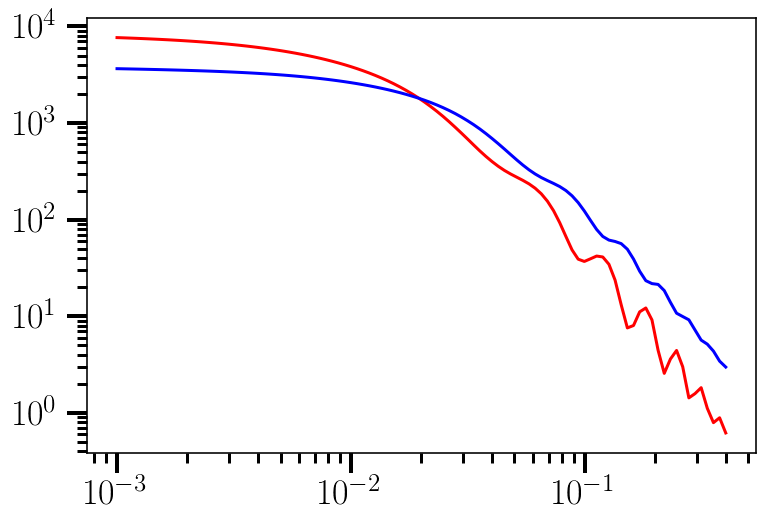

In [24]:
plt.plot(ks,Pk_l1_wa,color='red')
plt.plot(ks,-Pk_l3_wa.imag,color='blue')
plt.xscale('log')
plt.yscale('log')

In [25]:
import scipy 

In [26]:
#3rd order parts
def pk_dipo_3(kk,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    
    return -1j*f*(2*t - 1)*(2*Pkddd*kk**3*(-12*b1*(t*(t - 1) + 1) + f*(-t*(109*t - 109) + 4)) + 48*Pks*(3*b1*(t*(t - 1) + 1) + 2*f*t*(t - 1)) + 12*kk*(Pkd*(4*b1*(t*(t - 1) + 1) + f*(-t*(97*t - 97) - 4)) + Pkdd*kk*(-10*b1*(t*(t - 1) + 1) - 107*f*t*(t - 1))))/(105*d**3*kk**3)

def pk_octo_3(kk,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    return -8*1j*f*(2*t - 1)*(Pkddd*kk**3*(77*b1*(t*(t - 1) + 1) + 3*f*(t*(3*t - 3) + 7)) + 24*Pks*(77*b1*(t*(t - 1) + 1) + 93*f*t*(t - 1) + 30*f) + 3*kk*(-Pkd*(308*b1*(t*(t - 1) + 1) + 9*f*(t*(4*t - 4) + 13)) + Pkdd*f*kk*(-t*(56*t - 56) + 5)))/(495*d**3*kk**3)

def pk_octo_dfog_3(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd = Pk_d(kk)
    Pkdd = Pk_dd(kk)
    Pkddd = Pk_ddd(kk)
    return -7*1j*np.exp(-kk**2*sigma**2)*f*(2*t - 1)*(-8*Pks*(8*b1*kk**3*sigma**3*(t**2 - t + 1)*(20*kk**6*sigma**6 + 173*kk**4*sigma**4 + 735*kk**2*sigma**2 + 3150) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1*kk**2*sigma**2*(t**2 - t + 1)*(6*kk**6*sigma**6 - 81*kk**4*sigma**4 + 455*kk**2*sigma**2 - 1050) + f*(16*kk**8*sigma**8 - 520*kk**6*sigma**6 + 5780*kk**4*sigma**4 - 32130*kk**2*sigma**2 + t**2*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) - t*(24*kk**8*sigma**8 - 924*kk**6*sigma**6 + 10890*kk**4*sigma**4 - 62685*kk**2*sigma**2 + 151200) + 75600)) + 2*f*kk*sigma*(128*kk**8*sigma**8 + 1576*kk**6*sigma**6 + 13560*kk**4*sigma**4 + 54810*kk**2*sigma**2 + t**2*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) - t*(288*kk**8*sigma**8 + 3420*kk**6*sigma**6 + 28260*kk**4*sigma**4 + 114345*kk**2*sigma**2 + 453600) + 226800)) + kk*(2*Pkd*(4*b1*kk**3*sigma**3*(t**2 - t + 1)*(96*kk**6*sigma**6 + 892*kk**4*sigma**4 + 3780*kk**2*sigma**2 + 17325) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-2*b1*kk**2*sigma**2*(t**2 - t + 1)*(40*kk**6*sigma**6 - 484*kk**4*sigma**4 + 2590*kk**2*sigma**2 - 5775) + f*(40*kk**8*sigma**8 - 1048*kk**6*sigma**6 + 10970*kk**4*sigma**4 - 59220*kk**2*sigma**2 + t**2*(48*kk**8*sigma**8 - 2064*kk**6*sigma**6 + 22410*kk**4*sigma**4 - 120015*kk**2*sigma**2 + 274050) - t*(48*kk**8*sigma**8 - 2064*kk**6*sigma**6 + 22410*kk**4*sigma**4 - 120015*kk**2*sigma**2 + 274050) + 137025)) + 2*f*kk*sigma*(224*kk**8*sigma**8 + 2740*kk**6*sigma**6 + 24090*kk**4*sigma**4 + 96390*kk**2*sigma**2 + t**2*(432*kk**8*sigma**8 + 5256*kk**6*sigma**6 + 46440*kk**4*sigma**4 + 188055*kk**2*sigma**2 + 822150) - t*(432*kk**8*sigma**8 + 5256*kk**6*sigma**6 + 46440*kk**4*sigma**4 + 188055*kk**2*sigma**2 + 822150) + 411075)) + kk*(2*Pkdd*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-2*b1*kk**2*sigma**2*(t**2 - t + 1)*(16*kk**6*sigma**6 - 160*kk**4*sigma**4 + 770*kk**2*sigma**2 - 1575) + f*(8*kk**8*sigma**8 - 200*kk**6*sigma**6 + 2010*kk**4*sigma**4 - 10500*kk**2*sigma**2 + t**2*(48*kk**8*sigma**8 - 576*kk**6*sigma**6 + 4690*kk**4*sigma**4 - 22575*kk**2*sigma**2 + 47250) + t*(-48*kk**8*sigma**8 + 576*kk**6*sigma**6 - 4690*kk**4*sigma**4 + 22575*kk**2*sigma**2 - 47250) + 23625)) - 2*kk*sigma*(2*b1*kk**2*sigma**2*(t**2 - t + 1)*(16*kk**6*sigma**6 + 200*kk**4*sigma**4 + 840*kk**2*sigma**2 + 4725) + f*(32*kk**8*sigma**8 + 420*kk**6*sigma**6 + 3930*kk**4*sigma**4 + 15750*kk**2*sigma**2 + t**2*(-16*kk**8*sigma**8 + 392*kk**6*sigma**6 + 6720*kk**4*sigma**4 + 26775*kk**2*sigma**2 + 141750) + t*(16*kk**8*sigma**8 - 392*kk**6*sigma**6 - 6720*kk**4*sigma**4 - 26775*kk**2*sigma**2 - 141750) + 70875))) + Pkddd*kk*(56*b1*kk**3*sigma**3*(t**2 - t + 1)*(2*kk**4*sigma**4 + 5*kk**2*sigma**2 + 75) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1*kk**2*sigma**2*(t**2 - t + 1)*(4*kk**6*sigma**6 - 28*kk**4*sigma**4 + 105*kk**2*sigma**2 - 175) + f*(24*kk**6*sigma**6 - 280*kk**4*sigma**4 + 1470*kk**2*sigma**2 + t**2*(96*kk**6*sigma**6 - 850*kk**4*sigma**4 + 3465*kk**2*sigma**2 - 6300) + t*(-96*kk**6*sigma**6 + 850*kk**4*sigma**4 - 3465*kk**2*sigma**2 + 6300) - 3150)) + 2*f*kk*sigma*(32*kk**6*sigma**6 + 420*kk**4*sigma**4 + 1890*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 80*kk**6*sigma**6 + 660*kk**4*sigma**4 + 2205*kk**2*sigma**2 + 18900) - t*(16*kk**8*sigma**8 + 80*kk**6*sigma**6 + 660*kk**4*sigma**4 + 2205*kk**2*sigma**2 + 18900) + 9450)))))/(32*d**3*kk**14*sigma**11)


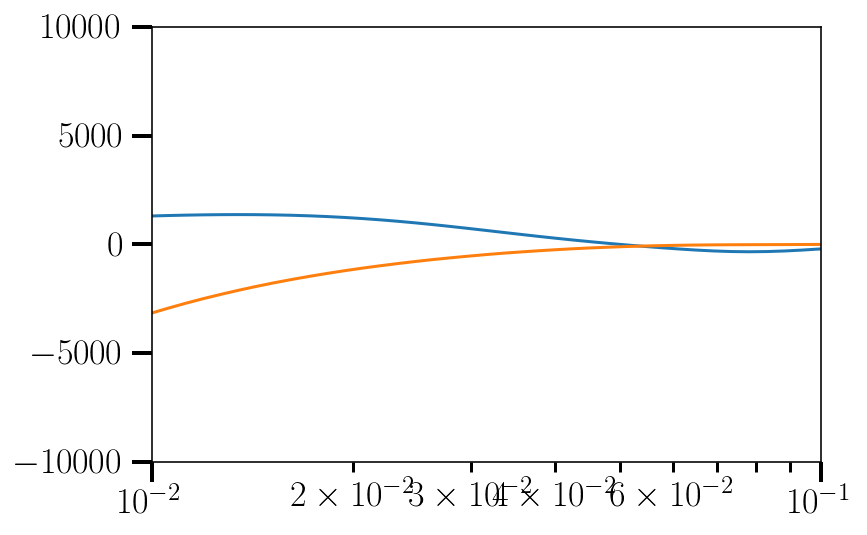

In [27]:
#PP functions with Dfog
def pk_mono_dfog(kk,sigma):
    Pks = Pk_(kk)
    return Pks*np.exp(-kk**2*sigma**2)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4 + 4*b1*f*kk**2*sigma**2 + 3*f**2) - 6*f**2*kk*sigma - 4*f*kk**3*sigma**3*(2*b1 + f))/(8*kk**5*sigma**5)  
    
def pk_mono_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(4*t**2 - 4*t - 1) + 4*b1*f*kk**3*sigma**3*(-4*kk**6*sigma**6 - 14*kk**4*sigma**4 - 33*kk**2*sigma**2 + t**2*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - t*(16*kk**6*sigma**6 + 16*kk**4*sigma**4 + 48*kk**2*sigma**2 + 72) - 54) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8 - 6*b1*f*kk**2*sigma**2*(kk**2*sigma**2 + 24*t**2 - 24*t - 18) + f**2*(7*kk**4*sigma**4 - 153*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 765)) + 2*f**2*kk*sigma*(-4*kk**8*sigma**8 - 22*kk**6*sigma**6 - 109*kk**4*sigma**4 - 357*kk**2*sigma**2 + t**2*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - t*(16*kk**8*sigma**8 + 32*kk**6*sigma**6 + 128*kk**4*sigma**4 + 336*kk**2*sigma**2 + 540) - 765)) + kk*(Pkd*(-8*b1**2*kk**5*sigma**5*(8*kk**2*sigma**2 + 3)*(4*t**2 - 4*t - 3) + 8*b1*f*kk**3*sigma**3*(24*kk**4*sigma**4 + 76*kk**2*sigma**2 - t**2*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + t*(64*kk**4*sigma**4 + 112*kk**2*sigma**2 + 180) + 135) - np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(8*kk**4*sigma**4 - 6*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 + 4) - t*(8*kk**2*sigma**2 + 4) - 3) + 4*b1*f*kk**2*sigma**2*(8*kk**4*sigma**4 - 14*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 180) + t*(-8*kk**2*sigma**2 + 180) + 135) + f**2*(56*kk**4*sigma**4 - 666*kk**2*sigma**2 + t**2*(120*kk**2*sigma**2 - 1620) - t*(120*kk**2*sigma**2 - 1620) + 2295)) + 2*f**2*kk*sigma*(48*kk**6*sigma**6 + 224*kk**4*sigma**4 + 864*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + t*(128*kk**6*sigma**6 + 352*kk**4*sigma**4 + 960*kk**2*sigma**2 + 1620) + 2295)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(2*kk**2*sigma**2 + 12*t**2 - 12*t - 9) + 8*b1*f*kk**3*sigma**3*(-10*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 36) - t*(16*kk**2*sigma**2 + 36) - 27) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(4*kk**4*sigma**4 - 8*kk**2*sigma**2 + t**2*(8*kk**2*sigma**2 - 12) + t*(-8*kk**2*sigma**2 + 12) + 9) - 4*b1*f*kk**2*sigma**2*(4*kk**4*sigma**4 + 8*kk**2*sigma**2 + t**2*(-8*kk**2*sigma**2 + 36) + t*(8*kk**2*sigma**2 - 36) - 27) + f**2*(28*kk**4*sigma**4 - 120*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 180) + t*(-24*kk**2*sigma**2 + 180) + 255)) + 2*f**2*kk*sigma*(-16*kk**4*sigma**4 - 50*kk**2*sigma**2 + t**2*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - t*(32*kk**4*sigma**4 + 96*kk**2*sigma**2 + 180) - 255))))/(128*d**2*kk**9*sigma**7)

def pk_quad_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  5*Pks*np.exp(-kk**2*sigma**2)*(-np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(-3*b1 + 2*f) - 45*f**2 + 6*f*kk**2*sigma**2*(-6*b1 + f)) - 90*f**2*kk*sigma - 24*f*kk**3*sigma**3*(3*b1 + 2*f) - kk**5*sigma**5*(24*b1**2 + 32*b1*f + 16*f**2))/(32*kk**7*sigma**7)

def pk_quad_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 5*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-4*kk**2*sigma**2 + t**2*(16*kk**2*sigma**2 + 24) - t*(16*kk**2*sigma**2 + 24) - 15) + 4*b1*f*kk**3*sigma**3*(-16*kk**8*sigma**8 - 80*kk**6*sigma**6 - 180*kk**4*sigma**4 - 381*kk**2*sigma**2 + t**2*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - t*(64*kk**8*sigma**8 + 160*kk**6*sigma**6 + 912*kk**4*sigma**4 + 2808*kk**2*sigma**2 + 5400) - 450) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(12*b1**2*kk**8*sigma**8*(-2*kk**2*sigma**2 - 8*t**2 + 8*t + 5) + 6*b1*f*kk**2*sigma**2*(2*kk**4*sigma**4 + 27*kk**2*sigma**2 + t**2*(264*kk**2*sigma**2 - 1800) - t*(264*kk**2*sigma**2 - 1800) + 150) + f**2*(-14*kk**6*sigma**6 + 297*kk**4*sigma**4 - 2385*kk**2*sigma**2 - t**2*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + t*(264*kk**4*sigma**4 - 9720*kk**2*sigma**2 + 56700) + 12285)) + 2*f**2*kk*sigma*(-16*kk**10*sigma**10 - 112*kk**8*sigma**8 - 484*kk**6*sigma**6 - 1983*kk**4*sigma**4 - 5805*kk**2*sigma**2 + t**2*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - t*(64*kk**10*sigma**10 + 224*kk**8*sigma**8 + 1904*kk**6*sigma**6 + 8904*kk**4*sigma**4 + 28080*kk**2*sigma**2 + 56700) - 12285)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(24*kk**4*sigma**4 + 138*kk**2*sigma**2 - t**2*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + t*(128*kk**4*sigma**4 + 984*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-96*kk**6*sigma**6 - 328*kk**4*sigma**4 - 858*kk**2*sigma**2 + t**2*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - t*(256*kk**6*sigma**6 + 1792*kk**4*sigma**4 + 6264*kk**2*sigma**2 + 13500) - 1125) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-12*b1**2*kk**4*sigma**4*(16*kk**6*sigma**6 - 20*kk**4*sigma**4 + 36*kk**2*sigma**2 + t**2*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) - t*(144*kk**4*sigma**4 - 208*kk**2*sigma**2 - 180) + 15) + 4*b1*f*kk**2*sigma**2*(16*kk**6*sigma**6 + 44*kk**4*sigma**4 - 108*kk**2*sigma**2 + t**2*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - t*(16*kk**4*sigma**4 - 2736*kk**2*sigma**2 + 13500) - 1125) + f**2*(112*kk**6*sigma**6 - 1548*kk**4*sigma**4 + 10620*kk**2*sigma**2 + t**2*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - t*(1392*kk**4*sigma**4 - 36720*kk**2*sigma**2 + 170100) - 36855)) + 2*f**2*kk*sigma*(192*kk**8*sigma**8 + 896*kk**6*sigma**6 + 4296*kk**4*sigma**4 + 13950*kk**2*sigma**2 - t**2*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + t*(512*kk**8*sigma**8 + 4096*kk**6*sigma**6 + 22272*kk**4*sigma**4 + 76680*kk**2*sigma**2 + 170100) + 36855)) - Pkdd*kk*(8*b1**2*kk**5*sigma**5*(4*kk**4*sigma**4 + 12*kk**2*sigma**2 + t**2*(24*kk**2*sigma**2 - 540) + t*(-24*kk**2*sigma**2 + 540) + 45) - 8*b1*f*kk**3*sigma**3*(-28*kk**4*sigma**4 - 96*kk**2*sigma**2 + t**2*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - t*(64*kk**4*sigma**4 + 648*kk**2*sigma**2 + 2700) - 225) + np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(8*kk**6*sigma**6 - 4*kk**4*sigma**4 + 18*kk**2*sigma**2 + t**2*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - t*(112*kk**4*sigma**4 - 384*kk**2*sigma**2 + 540) - 45) - 4*b1*f*kk**2*sigma**2*(8*kk**6*sigma**6 + 4*kk**4*sigma**4 - 54*kk**2*sigma**2 - t**2*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + t*(112*kk**4*sigma**4 - 1152*kk**2*sigma**2 + 2700) + 225) + f**2*(56*kk**6*sigma**6 - 492*kk**4*sigma**4 + 1950*kk**2*sigma**2 + t**2*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - t*(336*kk**4*sigma**4 - 5760*kk**2*sigma**2 + 18900) - 4095)) + 2*f**2*kk*sigma*(64*kk**6*sigma**6 + 284*kk**4*sigma**4 + 780*kk**2*sigma**2 - t**2*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + t*(128*kk**6*sigma**6 + 1536*kk**4*sigma**4 + 6840*kk**2*sigma**2 + 18900) + 4095))))/(512*d**2*kk**11*sigma**9)

def pk_dipo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return 3*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(Pkd*kk*(-8*b1**2*kk**6*sigma**6 + 4*b1*kk**4*sigma**4*(3*b1 - 2*f) + 45*f**2 - 6*f*kk**2*sigma**2*(-6*b1 + f)) - 4*Pks*(4*b1**2*kk**6*sigma**6 + 45*f**2 - 3*f*kk**2*sigma**2*(-6*b1 + f))) + 2*kk*sigma*(-Pkd*kk*(45*f**2 + 12*f*kk**2*sigma**2*(3*b1 + 2*f) + kk**4*sigma**4*(12*b1**2 + 16*b1*f + 8*f**2)) + 4*Pks*(45*f**2 + 2*f*kk**4*sigma**4*(6*b1 + 5*f) + 9*f*kk**2*sigma**2*(2*b1 + 3*f) + 4*kk**6*sigma**6*(b1 + f)**2)))/(32*d*kk**8*sigma**7)
            
def pk_octo_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    return  7*1j*np.exp(-kk**2*sigma**2)*(2*t - 1)*(Pkd*kk*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-4*b1 + f) + 875*f**2 + f*kk**2*sigma**2*(500*b1 - 240*f) + kk**4*sigma**4*(100*b1**2 - 192*b1*f + 12*f**2)) - 5250*f**2*kk*sigma - 20*f*kk**3*sigma**3*(150*b1 + 103*f) - kk**7*sigma**7*(16*b1**2 + 128*b1*f + 64*f**2) - kk**5*sigma**5*(600*b1**2 + 848*b1*f + 512*f**2)) + 4*Pks*(-3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-8*b1**2*kk**8*sigma**8 + 20*b1**2*kk**6*sigma**6 + 875*f**2 + 6*f*kk**4*sigma**4*(-6*b1 + f) + f*kk**2*sigma**2*(250*b1 - 165*f)) + 5250*f**2*kk*sigma + 8*f*kk**5*sigma**5*(98*b1 + 97*f) + 10*f*kk**3*sigma**3*(150*b1 + 251*f) + 32*kk**9*sigma**9*(b1 + f)**2 + kk**7*sigma**7*(120*b1**2 + 256*b1*f + 160*f**2)))/(128*d*kk**10*sigma**9)

def pk_hexa_dfog1(kk,sigma):
    Pks = Pk_(kk)
    return (8*f**2 *Pks)/35

def pk_hexa_dfog(kk,sigma):
    Pks = Pk_(kk)
    return  9*Pks*np.exp(-kk**2*sigma**2)*(3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(16*b1**2*kk**8*sigma**8 + 16*b1*kk**6*sigma**6*(-5*b1 + f) + 1225*f**2 + f*kk**2*sigma**2*(700*b1 - 300*f) + kk**4*sigma**4*(140*b1**2 - 240*b1*f + 12*f**2)) - 7350*f**2*kk*sigma - 100*f*kk**3*sigma**3*(42*b1 + 31*f) - kk**7*sigma**7*(80*b1**2 + 256*b1*f + 128*f**2) - kk**5*sigma**5*(840*b1**2 + 1360*b1*f + 832*f**2))/(256*kk**9*sigma**9)

#Extra wide-angle contributions...
def pk_hexa_dfog_wa(kk,sigma,d,t):
    Pks = Pk_(kk)
    Pkd= Pk_d(kk)
    Pkdd= Pk_dd(kk)
    return 9*np.exp(-kk**2*sigma**2)*(8*Pks*(8*b1**2*kk**9*sigma**9*(-32*kk**4*sigma**4 - 190*kk**2*sigma**2 + t**2*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - t*(128*kk**4*sigma**4 + 640*kk**2*sigma**2 + 1680) - 735) + 4*b1*f*kk**3*sigma**3*(-128*kk**10*sigma**10 - 1088*kk**8*sigma**8 - 3456*kk**6*sigma**6 - 6898*kk**4*sigma**4 - 1325*kk**2*sigma**2 + t**2*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) - t*(512*kk**10*sigma**10 + 3072*kk**8*sigma**8 + 25216*kk**6*sigma**6 + 132224*kk**4*sigma**4 + 452000*kk**2*sigma**2 + 1029000) + 51450) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**8*sigma**8*(12*kk**4*sigma**4 - 100*kk**2*sigma**2 + t**2*(160*kk**2*sigma**2 - 560) - t*(160*kk**2*sigma**2 - 560) + 245) - 2*b1*f*kk**2*sigma**2*(12*kk**6*sigma**6 + 1044*kk**4*sigma**4 - 11875*kk**2*sigma**2 + t**2*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) - t*(4608*kk**4*sigma**4 - 78000*kk**2*sigma**2 + 343000) + 17150) + f**2*(28*kk**8*sigma**8 - 552*kk**6*sigma**6 + 185*kk**4*sigma**4 + 22225*kk**2*sigma**2 + t**2*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) - t*(1536*kk**6*sigma**6 - 84960*kk**4*sigma**4 + 1113000*kk**2*sigma**2 - 4630500) + 33075)) + 2*f**2*kk*sigma*(-128*kk**12*sigma**12 - 1344*kk**10*sigma**10 - 5888*kk**8*sigma**8 - 24054*kk**6*sigma**6 - 71465*kk**4*sigma**4 - 132825*kk**2*sigma**2 + t**2*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - t*(512*kk**12*sigma**12 + 3584*kk**10*sigma**10 + 45696*kk**8*sigma**8 + 333312*kk**6*sigma**6 + 1733280*kk**4*sigma**4 + 5922000*kk**2*sigma**2 + 13891500) - 99225)) + kk*(Pkd*(8*b1**2*kk**5*sigma**5*(528*kk**6*sigma**6 + 348*kk**4*sigma**4 + 1900*kk**2*sigma**2 - t**2*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) + t*(1024*kk**6*sigma**6 + 14704*kk**4*sigma**4 + 101200*kk**2*sigma**2 + 73500) - 3675) - 8*b1*f*kk**3*sigma**3*(-768*kk**8*sigma**8 - 2512*kk**6*sigma**6 - 5660*kk**4*sigma**4 - 2000*kk**2*sigma**2 + t**2*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) - t*(2048*kk**8*sigma**8 + 39424*kk**6*sigma**6 + 261680*kk**4*sigma**4 + 1004000*kk**2*sigma**2 + 2572500) + 128625) - 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(-4*b1**2*kk**4*sigma**4*(96*kk**8*sigma**8 - 232*kk**6*sigma**6 + 524*kk**4*sigma**4 - 1450*kk**2*sigma**2 + t**2*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) - t*(2656*kk**6*sigma**6 - 13232*kk**4*sigma**4 + 17400*kk**2*sigma**2 + 24500) + 1225) + 4*b1*f*kk**2*sigma**2*(32*kk**8*sigma**8 + 424*kk**6*sigma**6 - 6180*kk**4*sigma**4 + 29250*kk**2*sigma**2 + t**2*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - t*(32*kk**6*sigma**6 - 16560*kk**4*sigma**4 + 237000*kk**2*sigma**2 - 857500) - 42875) + f**2*(224*kk**8*sigma**8 - 4104*kk**6*sigma**6 + 14380*kk**4*sigma**4 - 8050*kk**2*sigma**2 + t**2*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) - t*(8160*kk**6*sigma**6 - 364080*kk**4*sigma**4 + 3927000*kk**2*sigma**2 - 13891500) + 99225)) + 2*f**2*kk*sigma*(1536*kk**10*sigma**10 + 7168*kk**8*sigma**8 + 32688*kk**6*sigma**6 + 106420*kk**4*sigma**4 + 174300*kk**2*sigma**2 - t**2*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + t*(4096*kk**10*sigma**10 + 82944*kk**8*sigma**8 + 737280*kk**6*sigma**6 + 4351440*kk**4*sigma**4 + 16002000*kk**2*sigma**2 + 41674500) + 297675)) + Pkdd*kk*(8*b1**2*kk**5*sigma**5*(24*kk**6*sigma**6 - 68*kk**4*sigma**4 - 850*kk**2*sigma**2 + t**2*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) - t*(1264*kk**4*sigma**4 + 400*kk**2*sigma**2 + 73500) + 3675) + 8*b1*f*kk**3*sigma**3*(-280*kk**6*sigma**6 - 684*kk**4*sigma**4 + 650*kk**2*sigma**2 + t**2*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) - t*(512*kk**6*sigma**6 + 17392*kk**4*sigma**4 + 100000*kk**2*sigma**2 + 514500) + 25725) + 3*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(4*b1**2*kk**4*sigma**4*(16*kk**8*sigma**8 + 48*kk**6*sigma**6 - 384*kk**4*sigma**4 + 1100*kk**2*sigma**2 + t**2*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - t*(672*kk**6*sigma**6 - 4688*kk**4*sigma**4 + 16200*kk**2*sigma**2 - 24500) - 1225) - 4*b1*f*kk**2*sigma**2*(16*kk**8*sigma**8 - 48*kk**6*sigma**6 + 1152*kk**4*sigma**4 - 5500*kk**2*sigma**2 - t**2*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + t*(672*kk**6*sigma**6 - 14064*kk**4*sigma**4 + 81000*kk**2*sigma**2 - 171500) + 8575) + f**2*(112*kk**8*sigma**8 - 2160*kk**6*sigma**6 + 9920*kk**4*sigma**4 - 17500*kk**2*sigma**2 + t**2*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) - t*(2016*kk**6*sigma**6 - 70320*kk**4*sigma**4 + 567000*kk**2*sigma**2 - 1543500) + 11025)) + 2*f**2*kk*sigma*(-512*kk**8*sigma**8 - 1880*kk**6*sigma**6 - 3580*kk**4*sigma**4 + 30450*kk**2*sigma**2 + t**2*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - t*(1024*kk**8*sigma**8 + 33792*kk**6*sigma**6 + 311760*kk**4*sigma**4 + 1386000*kk**2*sigma**2 + 4630500) - 33075))))/(4096*d**2*kk**13*sigma**11)

def pk_6_dfog(kk,sigma):
    Pks = Pk_(kk)
    return 13*Pks*np.exp(-kk**2*sigma**2)*(-5*np.sqrt(np.pi)*np.exp(kk**2*sigma**2)*scipy.special.erf(sigma*kk)*(32*b1**2*kk**10*sigma**10 + 16*b1*kk**8*sigma**8*(-21*b1 + 2*f) - 43659*f**2 + 882*f*kk**2*sigma**2*(-22*b1 + 15*f) + kk**6*sigma**6*(1512*b1**2 - 1008*b1*f + 24*f**2) - kk**4*sigma**4*(2772*b1**2 - 7560*b1*f + 1260*f**2)) - 436590*f**2*kk*sigma - 17640*f*kk**3*sigma**3*(11*b1 + 9*f) - kk**9*sigma**9*(672*b1**2 + 1024*b1*f + 512*f**2) - kk**7*sigma**7*(3360*b1**2 + 11424*b1*f + 6144*f**2) - kk**5*sigma**5*(27720*b1**2 + 53760*b1*f + 40824*f**2))/(1024*kk**11*sigma**11)

#plt.plot(ks,pk_hexa_dfog(ks,10)+pk_hexa_dfog_wa(ks,10,560,0))
plt.plot(ks,pk_hexa_dfog(ks,10))
plt.plot(ks,pk_hexa_dfog_wa(ks,10,560,0))
plt.ylim(-1e+4,1e+4)
plt.xlim(1e-2,1e-1)
plt.xscale('log')


NameError: name 'pk_mono_dfog1' is not defined

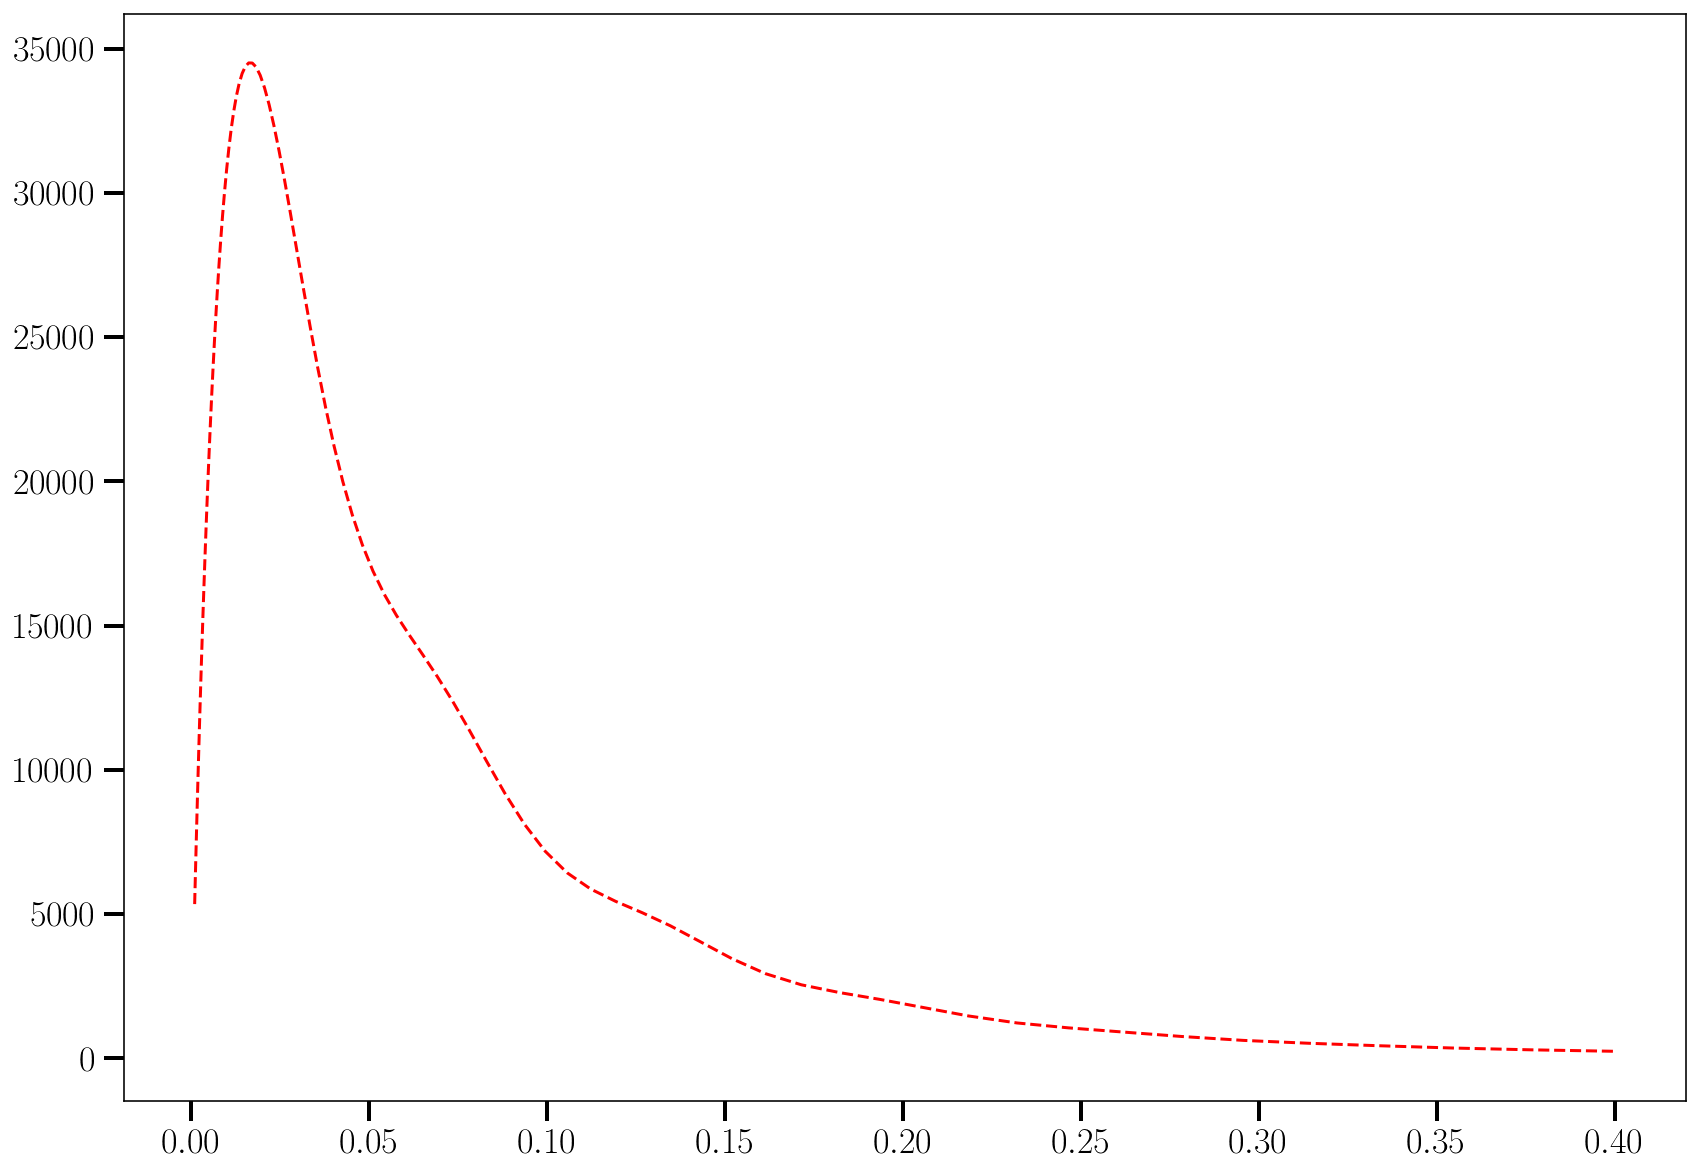

In [28]:
plt.figure(figsize=(14,10))
plt.plot(ks,np.abs(pk_mono_dfog(ks,5.3)),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_mono_dfog1(ks,5.3)),color='blue',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,5.3,500,0)),color='red',linestyle='--')
#plt.plot(ks,np.abs(pk_mono_dfog1_wa(ks,8,500,0)),color='blue',linestyle='--')
plt.yscale('log')
plt.xscale('log')

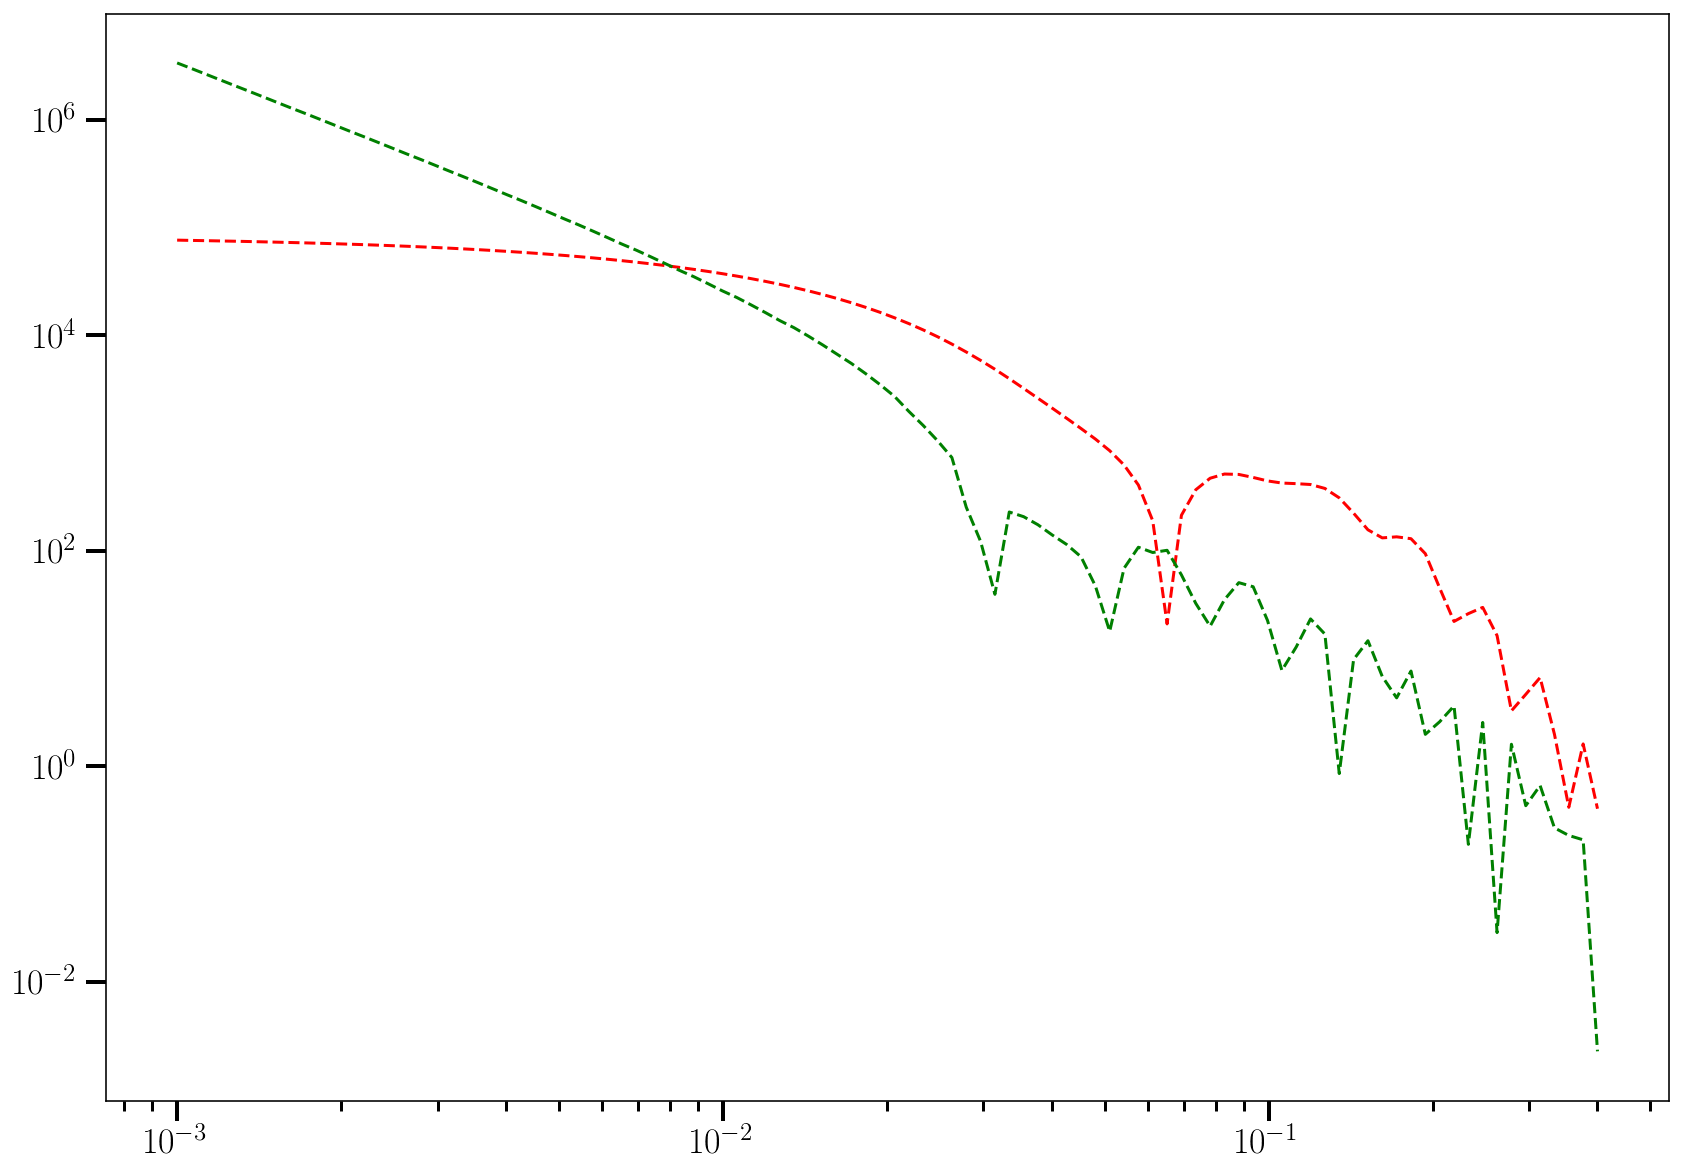

In [29]:
sigma =10
plt.figure(figsize=(14,10))
d=100
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,sigma,d,t).imag),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_dipo_3(ks,d,0).imag),color='green',linestyle='--')
#plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,sigma,d,t)),color='blue',linestyle='--')

#plt.plot(ks,Pk_l1_wa,color='red')
#plt.plot(ks,-Pk_l3_wa.imag,color='blue')

#plt.ylim(-1e4,1e4)
plt.yscale('log')
plt.xscale('log')

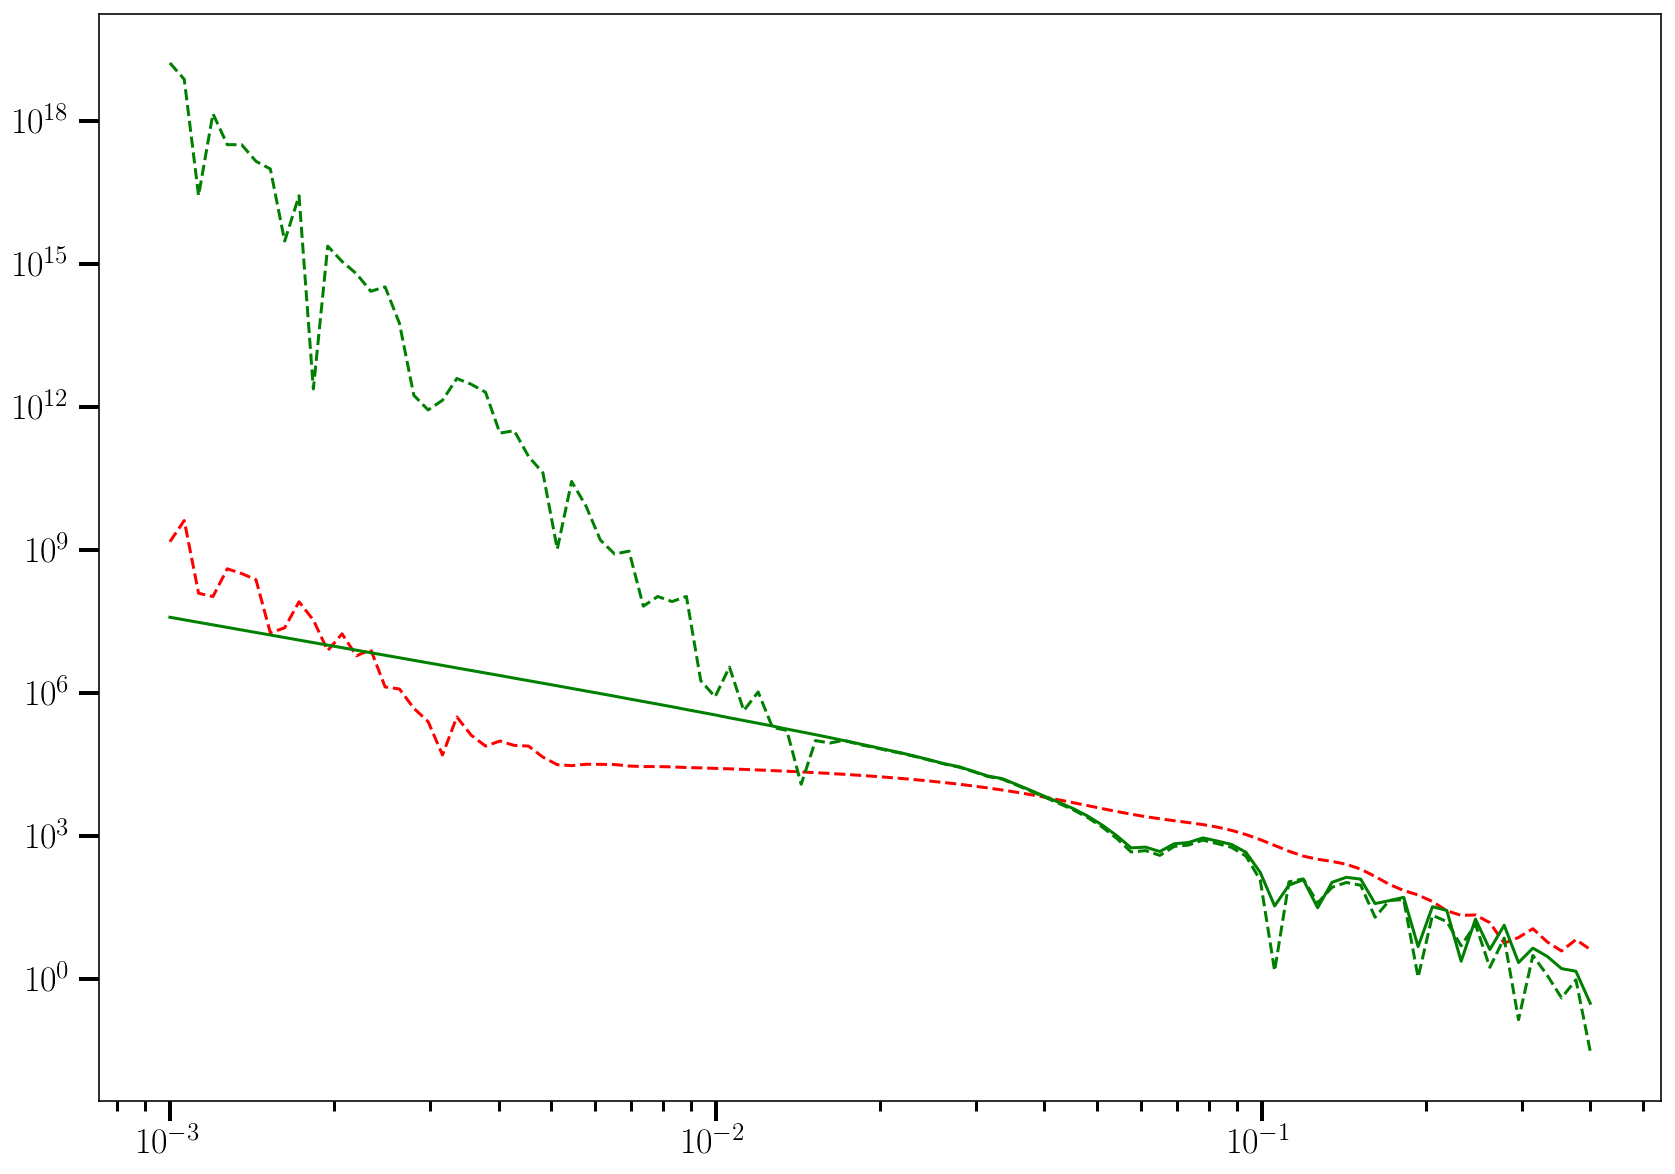

In [911]:
sigma = 5
plt.figure(figsize=(14,10))
d=100
plt.plot(ks,np.abs(pk_octo_dfog_wa(ks,sigma,d,t).imag),color='red',linestyle='--')
plt.plot(ks,np.abs(pk_octo_3(ks,d,0).imag),color='green',linestyle='-')
plt.plot(ks,np.abs(pk_octo_dfog_3(ks,sigma,d,0).imag),color='green',linestyle='--')

#plt.plot(ks,Pk_l1_wa,color='red')
#plt.plot(ks,-Pk_l3_wa.imag,color='blue')

#plt.ylim(1e+3,1e8)
plt.yscale('log')
plt.xscale('log')

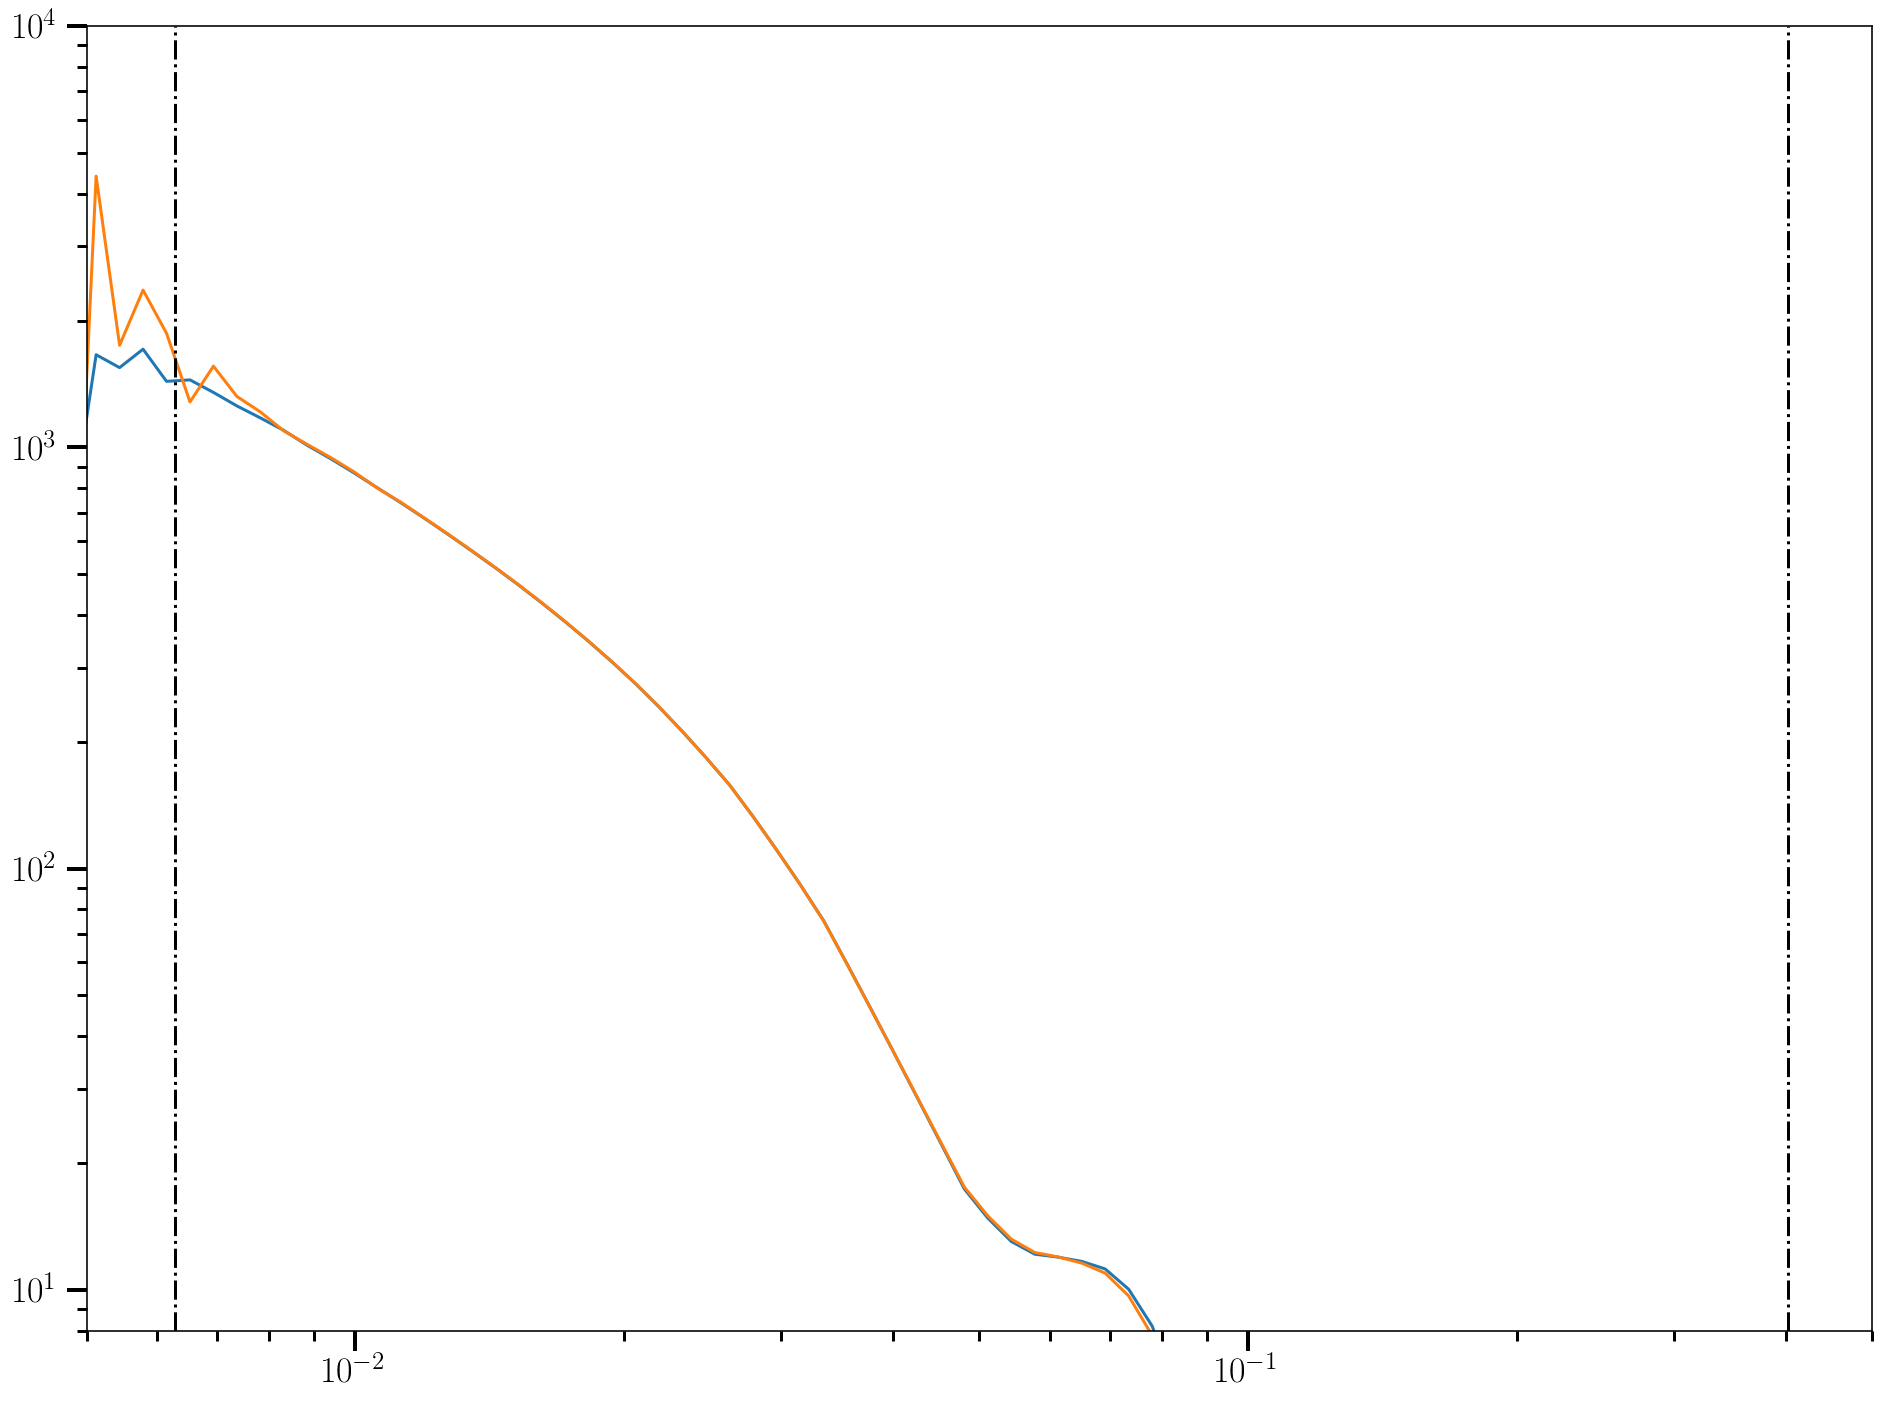

In [380]:
plt.figure(figsize=(16,12))
#plt.plot(ks,Pl2_pp,'k')
plt.plot(ks,-pk_quad_dfog_wa(ks,10,1000,0))
plt.plot(ks,-pk_quad_dfog_wa1(ks,4,1000,0))
#plt.plot(ks,np.abs(Pk_l2_wa))


plt.axvline(x = grid_info[5], linestyle='-.', color = 'black')
plt.axvline(x = grid_info[6], linestyle='-.', color = 'black')

plt.ylim(0.8e+1,1e+4)
plt.xlim(5e-3,5e-1)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
#plt.plot(ks,pk_mono_dfog(ks,5))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(pk_mono_dfog(ks,10)+Pk_l0_wa1))
#plt.plot(ks,np.abs(pk_quad_dfog(ks,10)+pk_quad_dfog_wa(ks,10,0)),'--')

plt.plot(ks,Pl0_pp)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
plt.plot(ks,np.abs(pk_dipo_dfog_wa(ks,10,0)))
plt.plot(ks,Pk_l1_wa)
#plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(ks,np.abs(pk_mono_dfog_wa(ks,10,0)))
plt.plot(ks,np.abs(Pk_l0_wa1))

plt.xscale('log')
plt.yscale('log')
plt.grid(ls='--',lw=0.75)